# Graph Sampling


## Basic useful definitions

A graph $G=(V,E)$ is a pair of $n$ nodes $u \in V$ and a set of unordered pairs of $m$ edges $e_{uv} = (u,v) \in E$. Without any loss of generality we will consider here only cases of undirected and unweighted $G$ graphs. These are simply a special case of graphs where all weights are unitary and for every edge $(u,v)$ there is also the opposite $(v,u)$.

Some notations:
- $\mathcal{N}(u)=\{v \in V \::\: (u,v)\in E \}$ is the **neighborhood** of a node and specifically the set of nodes connected to him. In the case of undirected graphs, closeness is a symmetric property: $v \in \mathcal{N}(u)\implies u \in \mathcal{N}(v)$;
- $\delta(u) = \{e_{uv} \in E \: :\: v \in \mathcal{N}(u)\}$ is the set of edges incident to a node and therefore which connect to a neighbor;
- $d_G(u) = |\mathcal{N}(u)| = |\delta(u)|$ is the **degree** of a node which indicates the number of edges incident to it or the number of neighbors;
- Given a subset of nodes $S \subset V$ are respectively indicated as:
 - $G_S = (V_S, E_S)$ the **induced graph** by $S$, where $V_S = S$ and $E_S = \{(u_S, v_S) \: : \: u_s \in V_S, v_s \in V_s, v_s \in \mathcal{N}(u_s)\}$. A **sampled graph** will look like this and have $n_S = |V_S|$ nodes and $m_S = |E_S|$ edges.


## Dataset

The dataset on which the sampling algorithms will be tested will be presented below.

In [145]:
import os
import torch
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from IPython.display import display, HTML
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx, to_dense_adj, subgraph, coalesce, to_undirected, k_hop_subgraph, remove_self_loops, degree, sort_edge_index
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import networkx as nx
from scipy.spatial.distance import jensenshannon
from networkx.algorithms import community

### Cora Dataset

The dataset contains a single graph $G$ made up of:
- $|V|=2708$ nodes each representing a different scientific publication to which a label relating to the topic and a numerical vector describing its content has been associated;
- $|E|=10556$ edges connecting two articles if there is a citation between them

In [146]:
dataset = Planetoid("Datasets", "Cora")
dataset._data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Let's visualize some properties of the dataset that we would like to maintain once the sampling has been done.



In [147]:
def graph_info(graph):
  net = to_networkx(graph, to_undirected=True)
  print(f'Number of nodes: {graph.num_nodes}')
  print(f'Number of node features: {graph.num_node_features}')
  print(f'Number of edges: {graph.num_edges}')
  print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
  print(f'Has self-loops: {graph.has_self_loops()}')
  print(f'Is undirected: {graph.is_undirected()}')
  print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
  print(f'Number of classes: {dataset.num_classes}')
  print(f'Number of connected components: {nx.number_connected_components(net)}')
  print(f'Density: {nx.density(net):.5f}')
  print(f'Average clustering coefficient: {nx.average_clustering(net):.5f}')
  print(f'Transitivity: {nx.transitivity(net):.5f}')

In [148]:
graph = dataset[0]
graph_info(graph)

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90
Number of classes: 7
Number of connected components: 78
Density: 0.00144
Average clustering coefficient: 0.24067
Transitivity: 0.09350


In [149]:
def deg_distribution(graph, degs_dist):
  net = to_networkx(graph, to_undirected=True)
  degrees = [val for (node, val) in net.degree()]
  display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
  
  avg_degree = graph.num_edges / graph.num_nodes
  
  if len(degs_dist) == 0:
    plt.figure(figsize=(10, 6))
    sns.histplot(degrees, bins=100, kde=True, color='b', alpha=0.3)
  else:
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    sns.histplot(degrees, bins=100, kde=True, color='b', alpha=0.3, ax=axs[0])
  
  degrees = collections.Counter(degrees)
  degrees = pd.DataFrame(degrees.items(), columns=['degree', 'count'])

  for i in range(degrees['degree'].min(), degrees['degree'].max()):
    if i not in degrees['degree'].values:
      degrees = pd.concat([degrees, pd.DataFrame([{'degree': i, 'count': 0}])], ignore_index=True)
        
  degrees = degrees.sort_values(by='degree')
  
  if len(degs_dist) == 0:
  
    plt.xlabel("node degree")
    plt.ylabel("frequency")
    plt.title("Node degree distribution")
  
    plt.axvline(avg_degree, color='r', linestyle='dashed', linewidth=1)
    plt.text(avg_degree + 1, 100, f'Average degree: {avg_degree:.2f}', color='r')
  
    plt.show()
  
  else:
    axs[0].set_xlabel("node degree")
    axs[0].set_ylabel("frequency")
    axs[0].set_title("Node degree distribution")
    
    axs[0].axvline(avg_degree, color='r', linestyle='dashed', linewidth=1)
    axs[0].text(avg_degree + 1, 100, f'Average degree: {avg_degree:.2f}', color='r')
    
  
  if len(degs_dist) == 0:
    curr_dist_degree = degrees['count'] / degrees['count'].sum()
    curr_dist_degree = curr_dist_degree.values
    curr_dist_degree = np.insert(curr_dist_degree, 0, 0)
    return curr_dist_degree
  
  else:
    
    if 0 not in degrees['degree'].values:
      degrees = pd.concat([degrees, pd.DataFrame([{'degree': 0, 'count': 0}])], ignore_index=True)
    
    for i in range(degs_dist.shape[0] - degrees.shape[0]):
      deg = degrees['degree'].max() + 1
      degrees = pd.concat([degrees, pd.DataFrame([{'degree': deg, 'count': 0}])], ignore_index=True)
    
    
    curr_dist_degree = degrees['count'] / degrees['count'].sum()
    curr_dist_degree = curr_dist_degree.values
    
    divergence = jensenshannon(degs_dist, curr_dist_degree)
  
    axs[1].plot(degs_dist, label='Initial distribution', color='b')
    axs[1].plot(curr_dist_degree, label='Current distribution', color='r')
    axs[1].set_xlabel("node degree")
    axs[1].set_title("Jensen-Shannon divergence")
    # add the divergence value to the plot
    axs[1].text(20, 0.20, f'Divergence: {divergence:.4f}', color='r')
    
    plt.legend()
    plt.show()
    
    return degs_dist

count  mean   std  min  25%  50%  75%    max
0  2708.0   3.9  5.23  1.0  2.0  3.0  5.0  168.0

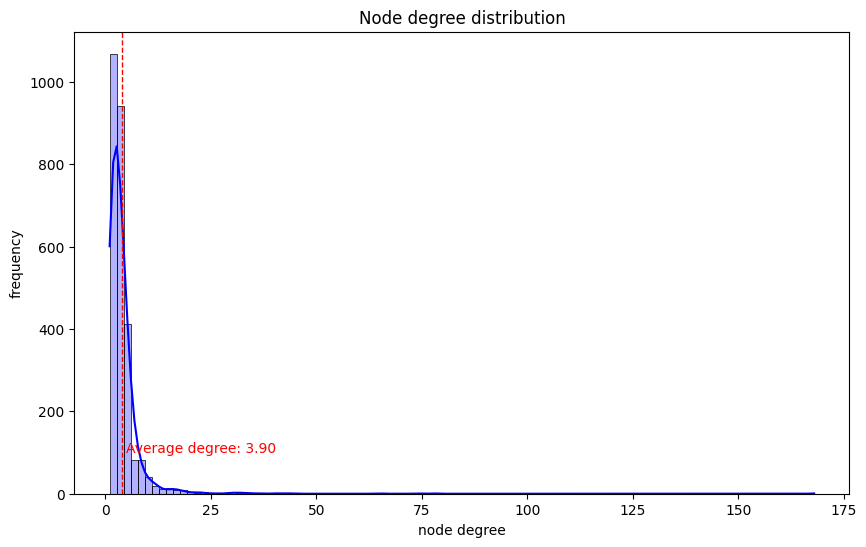

In [150]:
degs_dist = []
degs_dist = deg_distribution(graph, degs_dist)

In [151]:
def class_distribution(graph, labels, class_dist):
  counter = collections.Counter(graph.y.numpy())
  counter = dict(counter)
  unique_labels = graph.y.unique()
  labels_name = {i.item(): labels[i.item()] for i in unique_labels}
  probs = [x[1]/len(graph.x) for x in sorted(counter.items())]
  
  if len(class_dist) == 0:
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(probs)), probs, color='b', alpha=0.3)
    for i, p in enumerate(probs):
      plt.text(i, p, f'{p:.2f}', ha='center', va='bottom')
  
    plt.xticks(unique_labels, labels_name.values(), rotation=90)
    plt.title("Class distribution")
    plt.show()
  
  else:
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs[0].bar(range(len(probs)), probs, color='b', alpha=0.3)
    for i, p in enumerate(probs):
      axs[0].text(i, p, f'{p:.2f}', ha='center', va='bottom')
  
    axs[0].set_xticks(unique_labels)
    axs[0].set_xticklabels(labels_name.values(), rotation=90)
    axs[0].set_title("Class distribution")
  
  if len(class_dist) == 0:
    return probs

  else:
    
    divergence = jensenshannon(class_dist, probs)
    
    # plot only the points of the 2 distributions
    axs[1].plot(class_dist, label='Initial distribution', color='b', marker='o', linestyle='None')
    axs[1].plot(probs, label='Current distribution', color='r', marker='o', linestyle='None')
    axs[1].set_title("Jensen-Shannon divergence: {:.4f}".format(divergence))
    
    # add the point values to the plot
    for i, p in enumerate(class_dist):
      axs[1].text(i + 0.2, p, f'{p:.2f}', ha='center', va='bottom', color='b')
      axs[1].plot([i, i], [class_dist[i], probs[i]], color='gray', linestyle='dashed')
    for i, p in enumerate(probs):
      axs[1].text(i + 0.2, p, f'{p:.2f}', ha='center', va='bottom', color='r')      
    
    plt.legend()
    plt.show()
    
    return class_dist
  


In [152]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

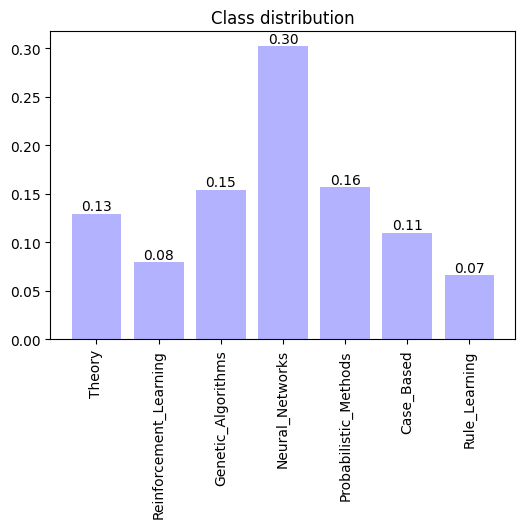

In [153]:
class_dist = []
class_dist = class_distribution(graph, label_dict, class_dist)

The term **homophily** refers to the fact that similar nodes in a graph are often connected. So let's see in what proportion the connections within the graph are between nodes with the same class and how many are between different classes.

In [154]:
def add_missing_keys(counter, num_classes):
  for x in range(num_classes): 
    if x not in counter.keys():
      counter[x] = 0
  return counter

def homophily_plot(graph, labels):
  source_labels = graph.y[graph.edge_index[0]].numpy()
  target_labels = graph.y[graph.edge_index[1]].numpy()

  connected_labels_set = np.stack((source_labels, target_labels), axis=0)
  
  num_labels = len(label_dict)
  label_probs = np.zeros((num_labels, num_labels))
  
  for i in range(num_labels):
    i_labels = connected_labels_set[:, connected_labels_set[0] == i]
    counter = collections.Counter(i_labels[1])
    if len(counter.keys()) < num_labels:
      counter = add_missing_keys(counter, num_labels)
    
    counter = dict(sorted(counter.items()))
    items = np.array(list(counter.values()))
    items = items / items.sum()
    label_probs[i] = items

  plt.figure(figsize=(6, 6))
  plt.rcParams["font.size"] = 10
  hm = sns.heatmap(
    label_probs,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
  labels_name = {i.item(): labels[i.item()] for i in graph.y.unique()}
  plt.xticks(np.arange(len(labels_name.keys()))+0.5, labels_name.values(), rotation=90, size=10)
  plt.yticks(np.arange(len(labels_name.keys()))+0.5, labels_name.values(), rotation=0, size=10)
  plt.title("Homophily plot")
  plt.show()


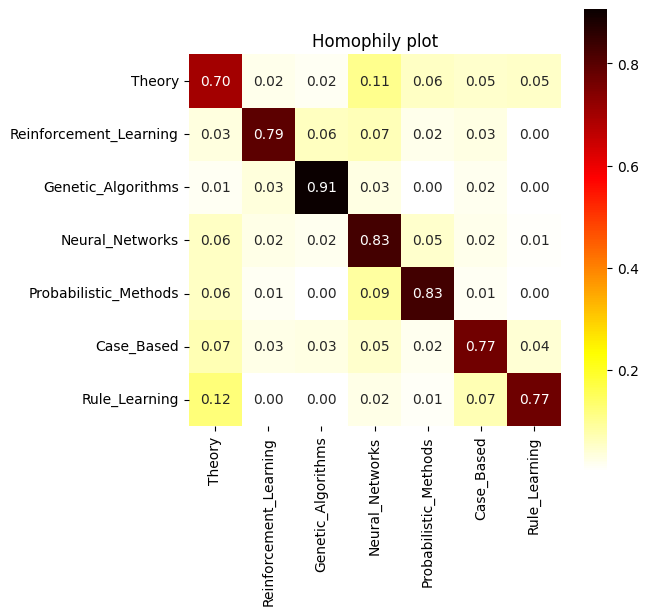

In [155]:
homophily_plot(graph, label_dict)

Let's visualize the entire graph

In [156]:
def visualize_graph(graph, title):
  net = to_networkx(graph, to_undirected=True)
  node_color = []
  nodelist = [[], [], [], [], [], [], []]
  colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
  labels = graph.y
  for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

  pos = nx.spring_layout(net, seed = 42)
  plt.figure(figsize = (10, 10))
  labellist = list(label_dict.values())
  for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(net, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)

  nx.draw_networkx_edges(net, pos, width = 0.5)
  plt.legend()
  plt.axis('off')
  plt.title(title)
  plt.show()
  plt.close()

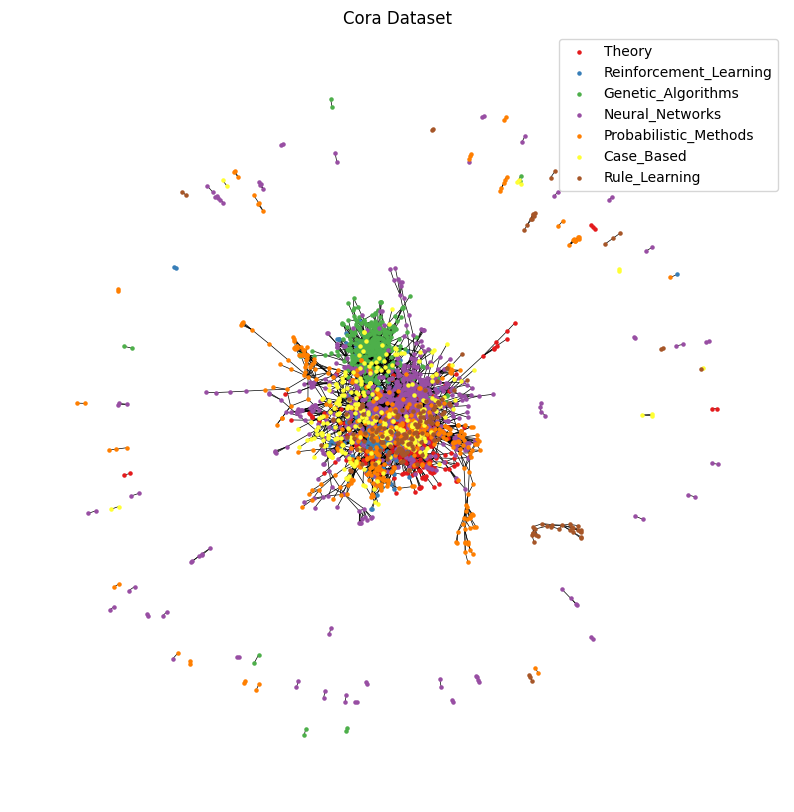

In [157]:
visualize_graph(graph, "Cora Dataset")

Although much larger datasets with millions of nodes exist in the literature, this graph already has a size large enough to justify the use of sampling methods and not too large that it cannot be handled easily enough in a notebook.

We would like to maintain most of the properties of the dataset seen in this section by applying sampling and reducing the dimensions.

In [158]:
def num_samples(graph, size_reduction):
  num_samples_nodes = int(graph.num_nodes * (1 - size_reduction))
  num_samples_edges = int(graph.num_edges * (1 - size_reduction))
  return num_samples_nodes, num_samples_edges

All the experiments that follow will be performed in accordance with the number of samples now defined on the nodes or edges depending on the technique.


The termination conditions usually used are a certain constant number of iterations (deterministic criterion) or a certain number of different nodes explored (stochastic criterion).


Given the lack of domain expert knowledge, every time we have to sample edges or nodes we will use a degree-induced distribution, in order to favor the exploration of **hubs** of the network, under the hypothesis that densely crowded areas surround nodes of high importance.
Depending on whether the entire graph or only the neighborhood of a node $\mathcal{N}(v_i)$ is considered, the normalization constants of the various distributions considered will change.


In the event that the stochastic algorithm defines a progressive path in the graph that allows returning to nodes already considered, the number of returns obtained can be plotted as the degree varies.

In [159]:
def node_dist_plot(node_dist_dict):
  graph = dataset[0]
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)

  plt_val = {}

  for key, count in node_dist_dict.items():
    deg = degs[key].item()
    if deg in plt_val:
      plt_val[deg] += count
    else:
      plt_val[deg] = count
    
  plt_val = np.array(list(plt_val.items()))
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_xlabel('Node Degree')
  ax.set_ylabel('Node count')
  ax.bar(plt_val[:, 0], plt_val[:, 1], label='Count')
  ax.tick_params(axis='y')

  fig.tight_layout()
  plt.show()

In [160]:
def analyze_sampling(graph, title, node_dist=None):
  graph_info(graph)
  deg_distribution(graph, degs_dist)
  class_distribution(graph, label_dict, class_dist)

  if node_dist is not None:
    node_dist_plot(node_dist)

  homophily_plot(graph, label_dict)
  visualize_graph(graph, title)

## Vertex Sampling (VS)

First $V_S\subset V$ nodes are sampled uniformly or in accordance with some distribution if knowledge about the domain is available and then $G_S=(V_S, E_S)$ is defined with $E_S \subset E$ is the set of all the edges we can take from $E$ such that they connect two nodes sampled in $V_S$.

In our case we will use the distribution on the nodes:
$$
\pi_{v_i} = \frac{d_G(v_i)}{\sum_{v_k \in V} d_G(v_k)}
$$
or the classic uniform distribution $\pi_{v_i} = \frac{1}{|V|}$.

In [161]:
def vertex_sampling(graph, num_samples, uniform=False):
  
  if not uniform:
    degs = degree(graph.edge_index[0], graph.num_nodes)
    probs = degs / torch.sum(degs)
    node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False, p=probs)
  else:
    node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False)
  
  sample_nodes = graph.x[node_samp_ids]
  sample_edges_index, _ = subgraph(torch.tensor(node_samp_ids),
                                                   graph.edge_index,
                                                   graph.edge_attr,
                                   relabel_nodes = True)
  sample_y = graph.y[node_samp_ids]

  sample_graph = Data(x=sample_nodes, edge_index=sample_edges_index, y=sample_y)

  return sample_graph

In [162]:
num_samples_nodes, _ = num_samples(graph, 0.7)
vs_graph = vertex_sampling(graph, num_samples_nodes, uniform=False)

Number of nodes: 812
Number of node features: 1433
Number of edges: 2152
Has isolated nodes: True
Has self-loops: False
Is undirected: True
Average node degree: 2.65
Number of classes: 7
Number of connected components: 135
Density: 0.00327
Average clustering coefficient: 0.21483
Transitivity: 0.11829


count  mean   std  min  25%  50%  75%   max
0  812.0  2.65  3.57  0.0  1.0  2.0  3.0  72.0

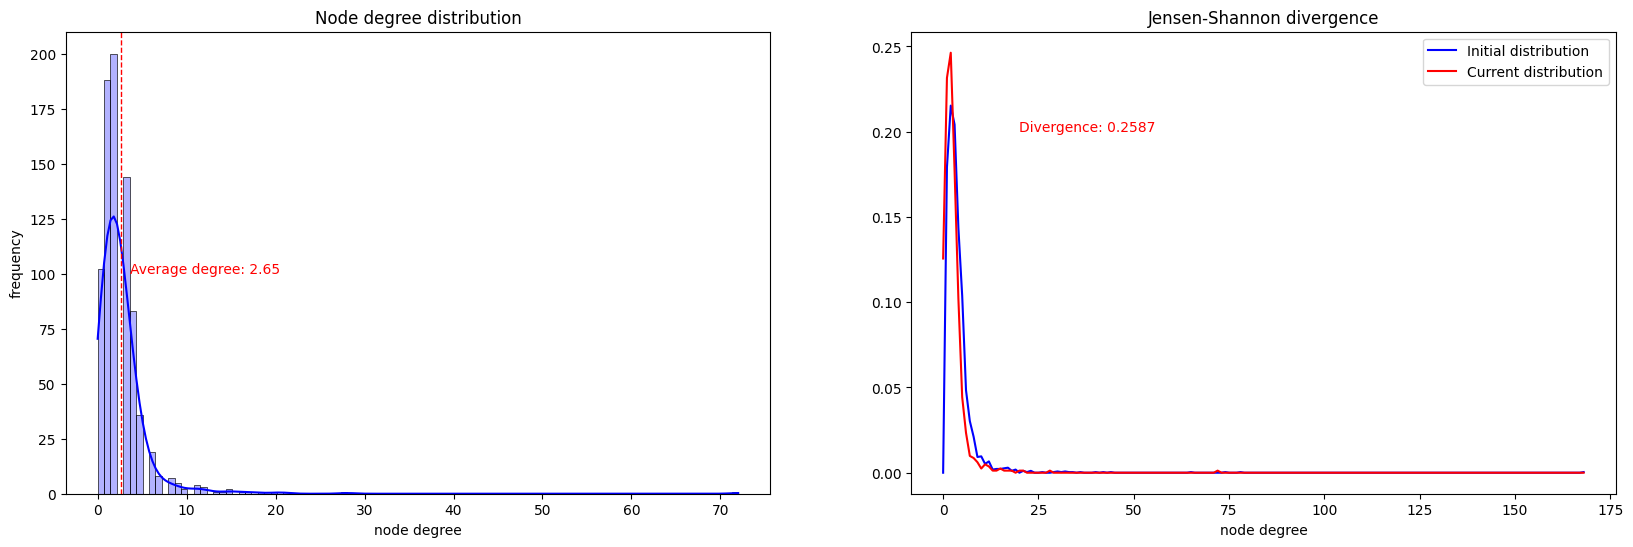

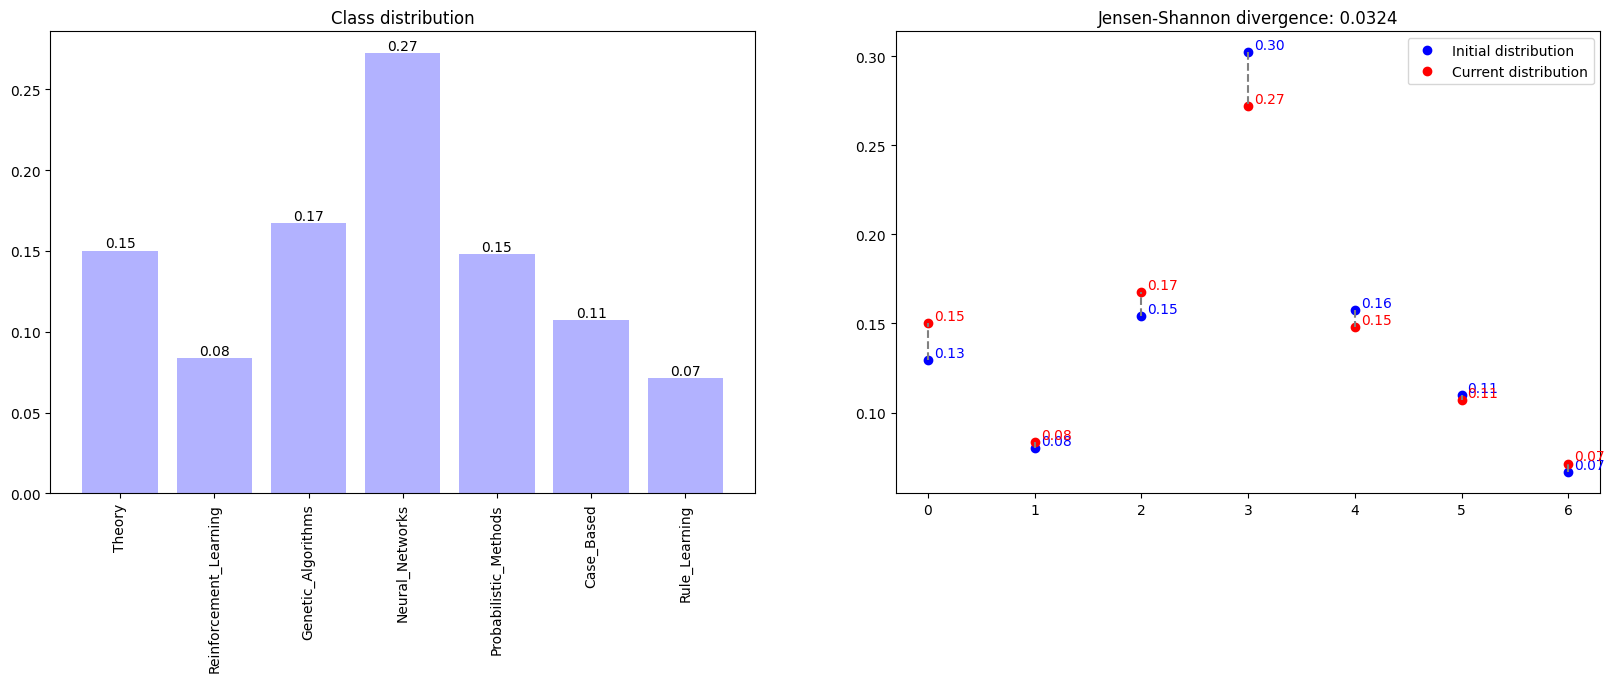

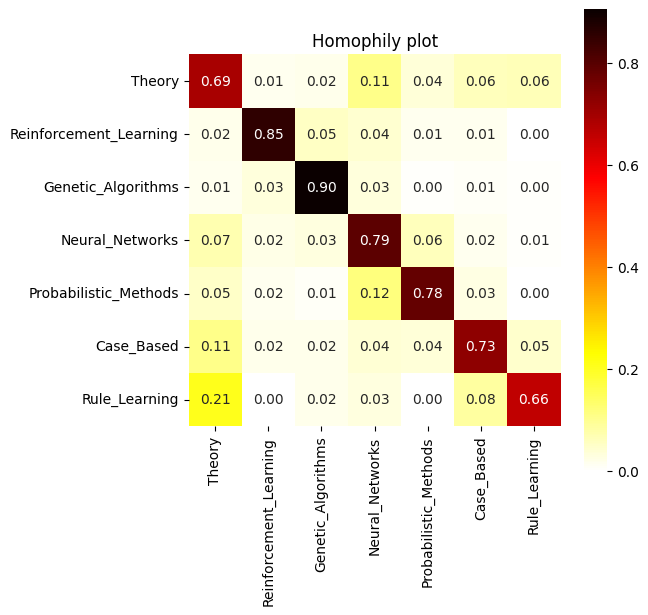

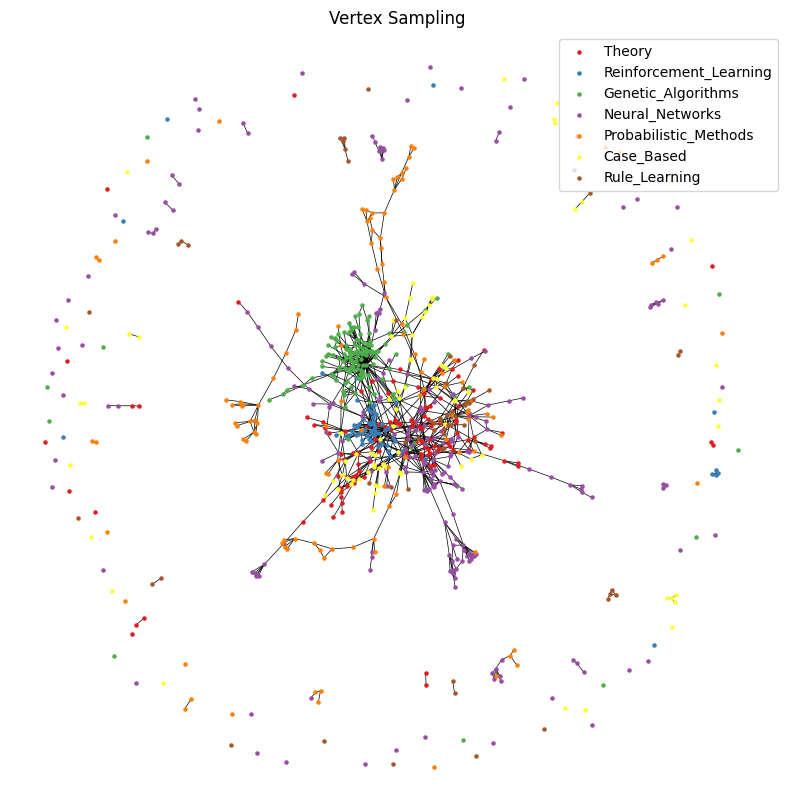

In [163]:
analyze_sampling(vs_graph, "Vertex Sampling")

## Vertex Sampling with Neighbourhood (VSN)

We first sample $\tilde{V}_S \subset V$ nodes and then set $V_S = \tilde{V}_S \cup \bigcup_{v \in \tilde{V}_S} \mathcal{N}(v)$ equal to the union of the sampled nodes and their entire neighborhood. Consequently we will have that $E_S = \bigcup_{v \in \tilde{V}_S} \delta(v)$ is the set of all edges incident to all nodes in $\tilde{V}_S$.

In [164]:
def vertex_sampling_neighbourhood(graph, num_samples, uniform=False):
  degs = degree(graph.edge_index[0], graph.num_nodes)
  avg_degree = torch.sum(degs) / graph.num_nodes
  num_samples = int(num_samples / avg_degree)
  if not uniform:  
    probs = degs / torch.sum(degs)
    node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False, p=probs)
  
  else:
    node_samp_ids = np.random.choice(graph.num_nodes, num_samples, replace=False)
    
  node_samp_ids, sample_edges, _, _  = k_hop_subgraph(torch.tensor(node_samp_ids),
                                                     1,
                                                     graph.edge_index,
                                                     relabel_nodes=True)
  sample_nodes = graph.x[node_samp_ids]
  sample_y = graph.y[node_samp_ids]

  sample_graph = Data(x=sample_nodes, edge_index=sample_edges, y=sample_y)
  return sample_graph

In [165]:
num_samples_nodes, _ = num_samples(graph, 0.7)
vsn_graph = vertex_sampling_neighbourhood(graph, num_samples_nodes, True)

Number of nodes: 736
Number of node features: 1433
Number of edges: 2392
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.25
Number of classes: 7
Number of connected components: 34
Density: 0.00442
Average clustering coefficient: 0.36169
Transitivity: 0.20313


count  mean   std  min  25%  50%  75%   max
0  736.0  3.25  3.14  1.0  2.0  3.0  4.0  59.0

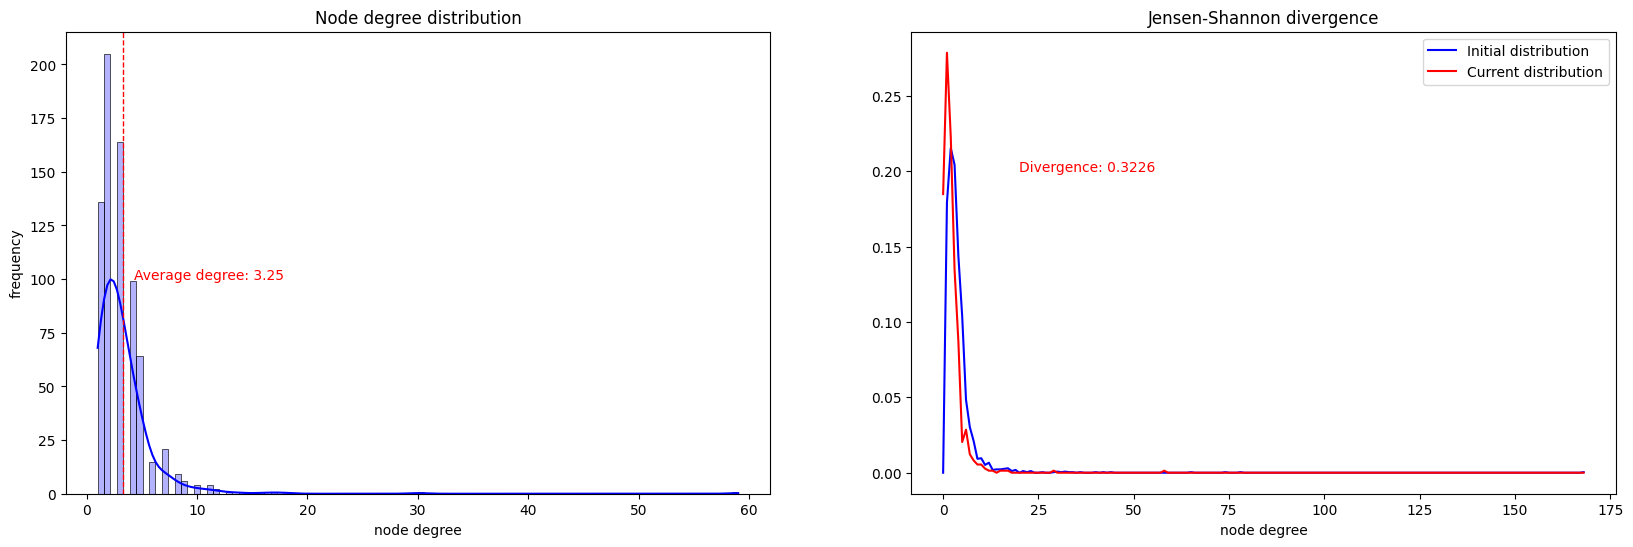

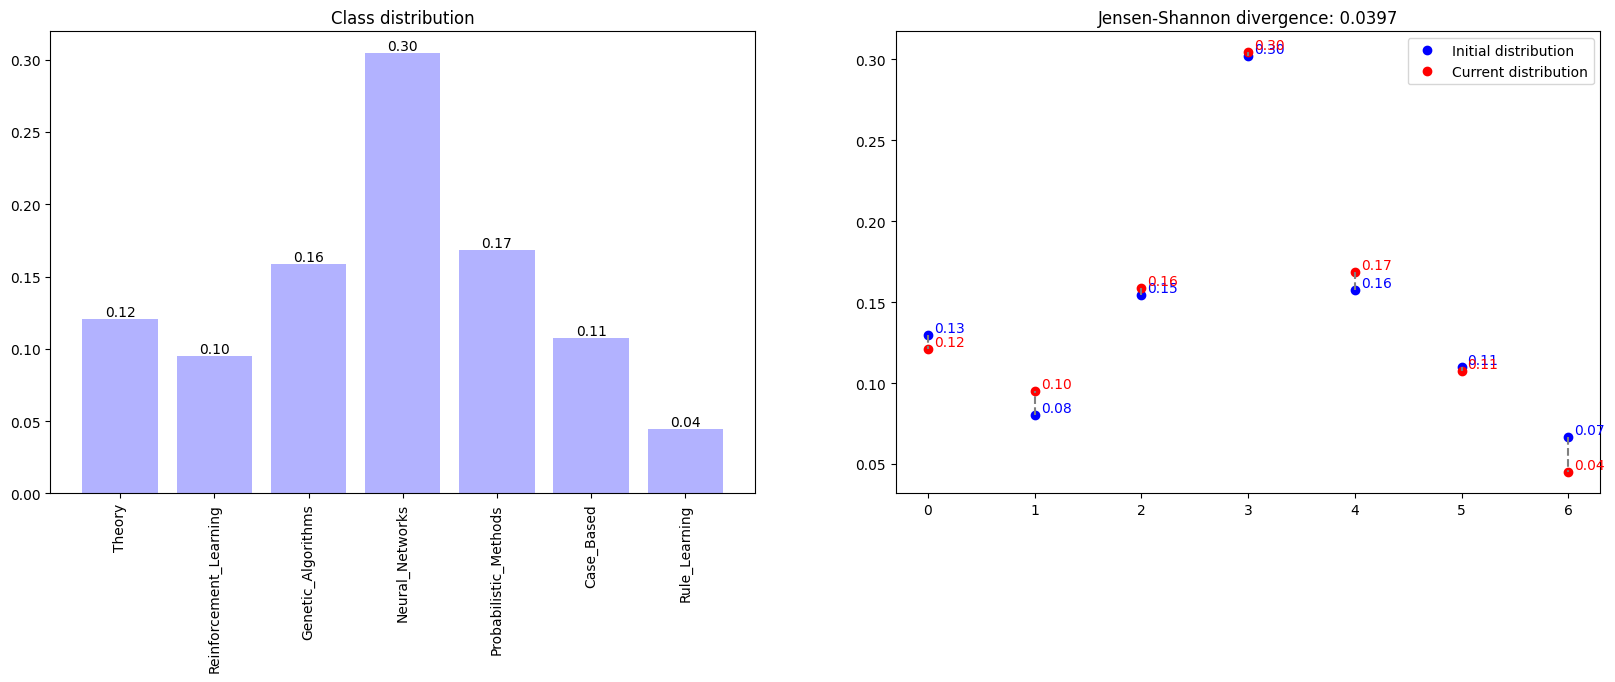

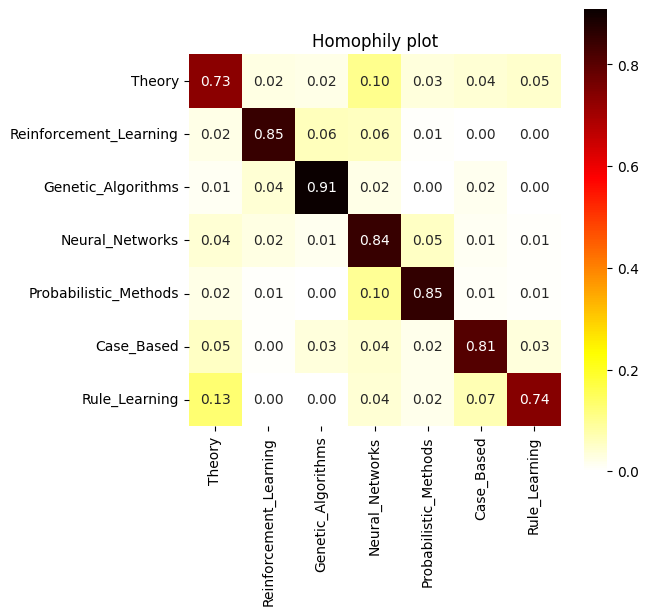

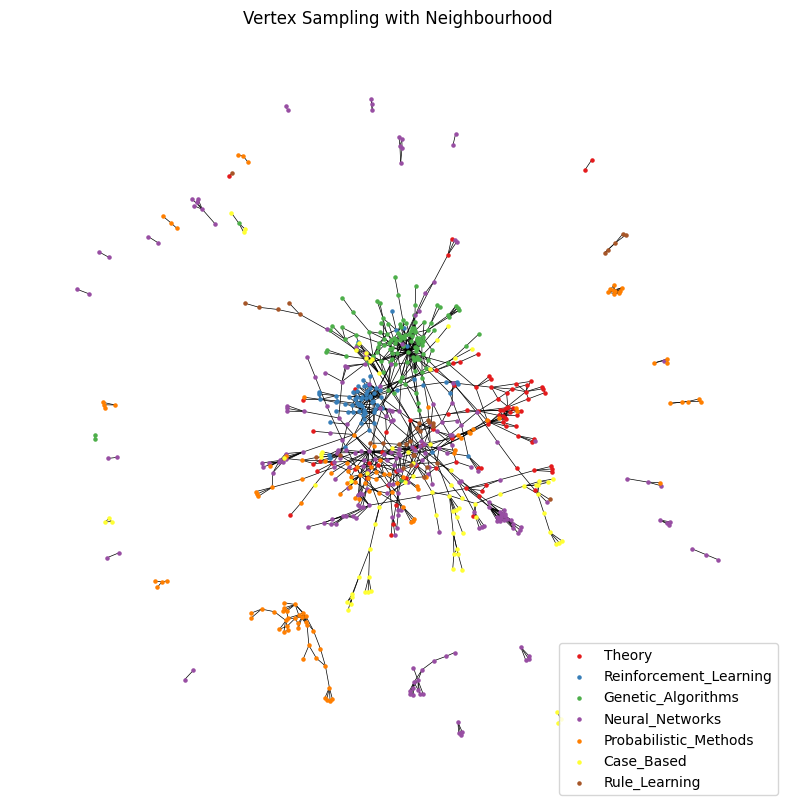

In [166]:
analyze_sampling(vsn_graph, "Vertex Sampling with Neighbourhood")

## Edge Sampling (ES)

In the opposite way to before, we first sample a certain number of edges $E_S$ and then we define the sampling graph $G_S=(V_S, E_S)$ in which $V_S$ is the set of all the nodes that appear in at least one of the sampled edges.

The distribution used on the edges is:
$$
\pi_{e_{ij}} = \frac{d_G(v_i) + d_G(v_j)}{\sum_{e_{kz} \in E} d_G(v_k) + d_G(v_z)}
$$
in which, compared to uniform distribution, more importance is given to edges that connect highly connected nodes in the network.

Also in this case, the uniform distribution $\pi_{e_{ij}} = \frac{1}{|E|}$ can be used.


In [167]:
def relabel_edge_index(node_ids, edge_index):
  node_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(node_ids)}
  relabeled_edge_index = torch.zeros_like(edge_index)
  for count, edge in enumerate(edge_index.t()):
    relabeled_edge_index.t()[count] = torch.tensor([node_mapping[edge[0].item()], node_mapping[edge[1].item()]])

  return relabeled_edge_index


def edge_sampling(graph, num_samples, uniform=False):

  num_unique_edges = int(num_samples * 0.5)
  
  sorted_edge_index = torch.sort(graph.edge_index, dim=0)[0]
  degs = degree(sorted_edge_index[0], graph.num_nodes)
  t_edge_index = sorted_edge_index.t()
  if not uniform:
  
    edge_probs = degs[t_edge_index[:,0:1].squeeze()] + degs[t_edge_index[:,1:2].squeeze()]
    edge_probs = (edge_probs / torch.sum(edge_probs)).reshape(1, -1)
  
  else:
    edge_probs = torch.ones((1, sorted_edge_index.shape[1])) / sorted_edge_index.shape[1]

  edge_index = torch.cat((sorted_edge_index, edge_probs))

  unique_edge_index, _ = torch.unique(edge_index, dim=1, return_inverse=True)

  final_probs = (2 * unique_edge_index.t()[:,2:3].squeeze()).numpy()

  final_probs =  final_probs / np.sum(final_probs)

  edge_samp_ids = np.sort(np.random.choice(unique_edge_index.shape[1],
                                           num_unique_edges,
                                           replace=False,
                                           p = final_probs
                                           ))

  sample_edges = (unique_edge_index[0:2, edge_samp_ids]).to(torch.long)

  sample_edges = to_undirected(sample_edges)

  sample_nodes_ids = sample_edges.t()[:,0:1].squeeze().unique()
  sample_nodes = graph.x[sample_nodes_ids]

  sample_y = graph.y[sample_nodes_ids]

  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [168]:
_, num_sample_edges = num_samples(graph, 0.85)
es_graph = edge_sampling(graph, num_sample_edges, False)

Number of nodes: 884
Number of node features: 1433
Number of edges: 1582
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 1.79
Number of classes: 7
Number of connected components: 149
Density: 0.00203
Average clustering coefficient: 0.03624
Transitivity: 0.00846


count  mean   std  min  25%  50%  75%    max
0  884.0  1.79  4.85  1.0  1.0  1.0  2.0  118.0

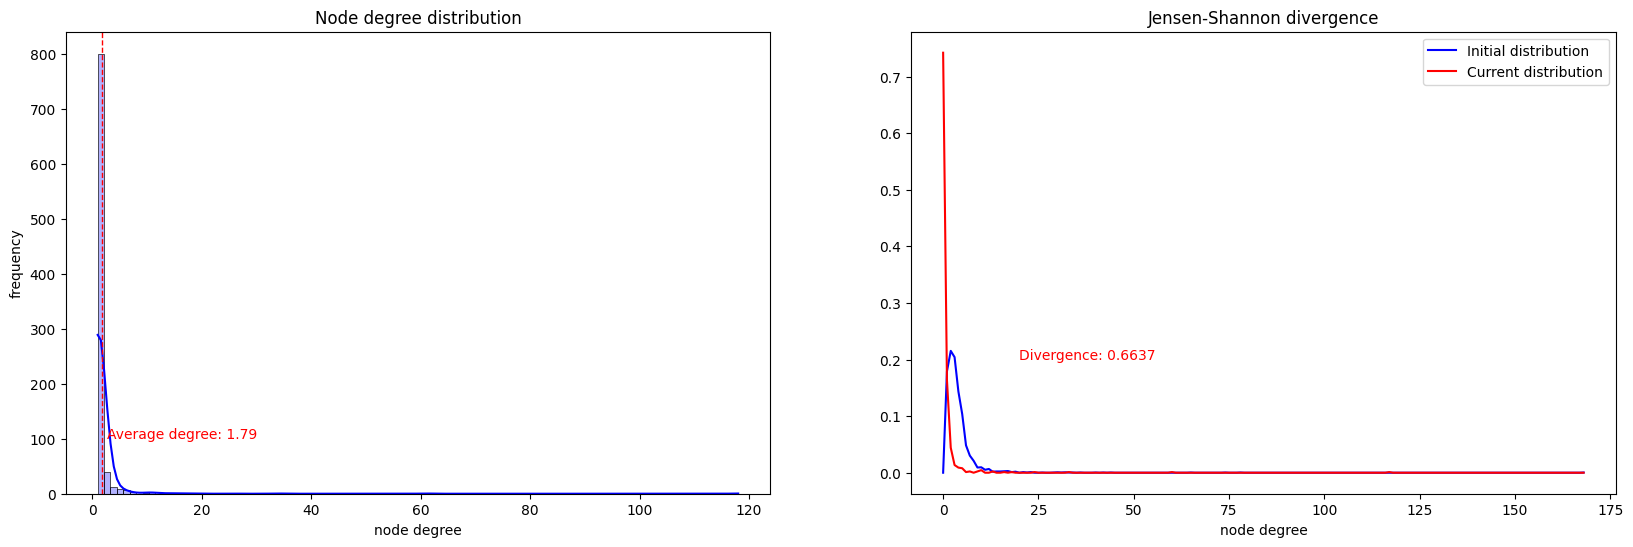

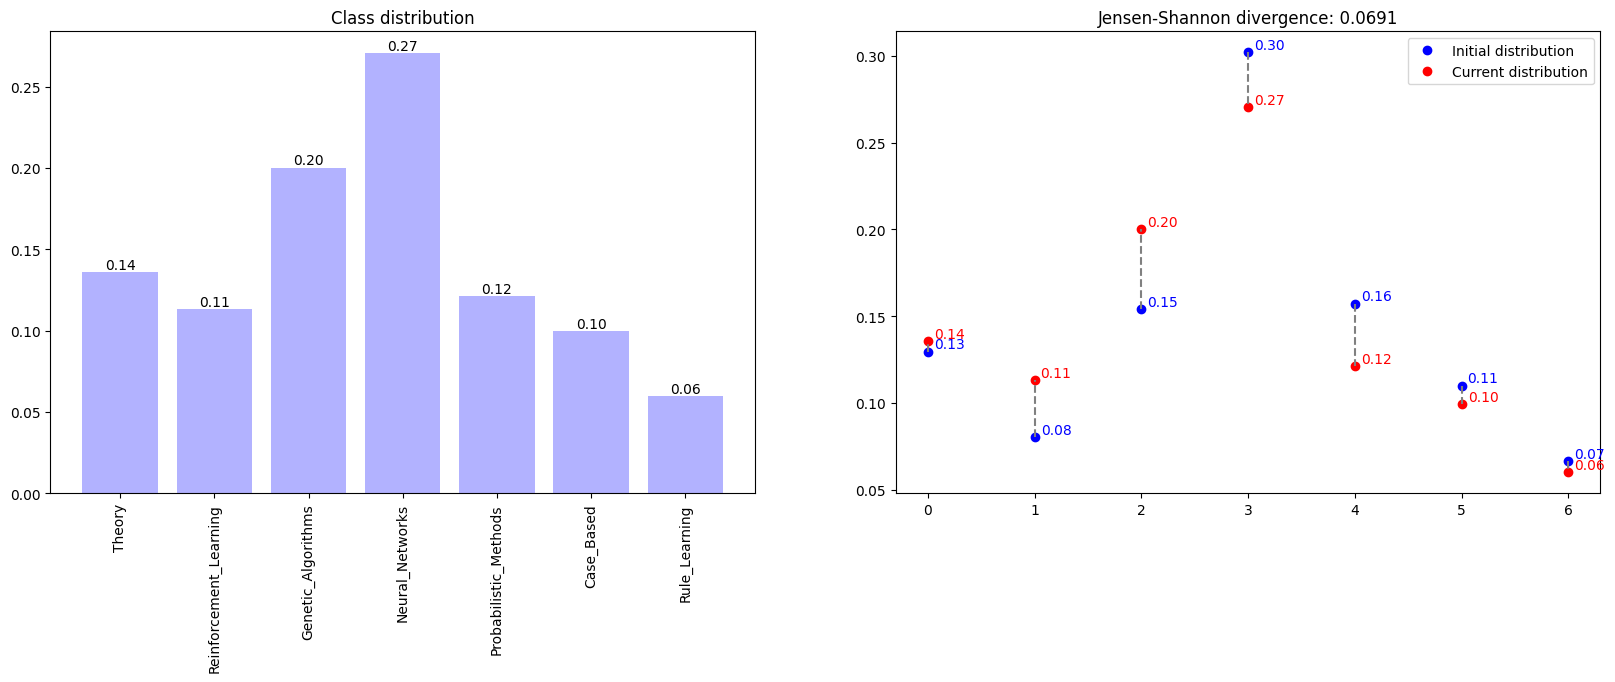

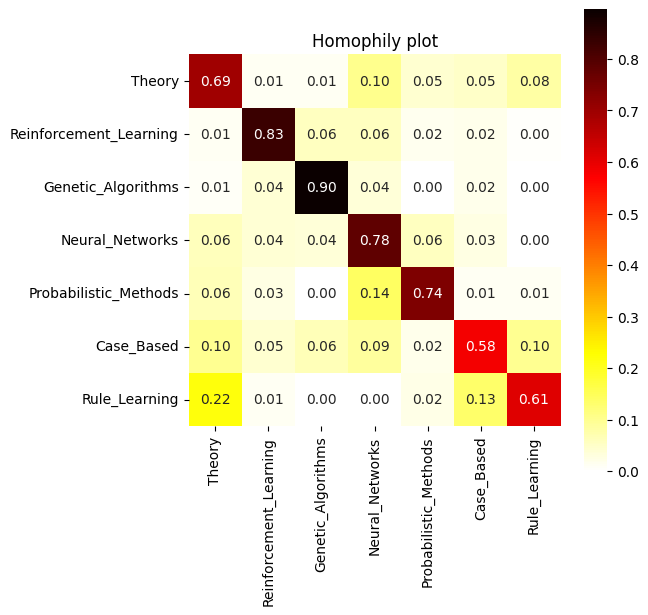

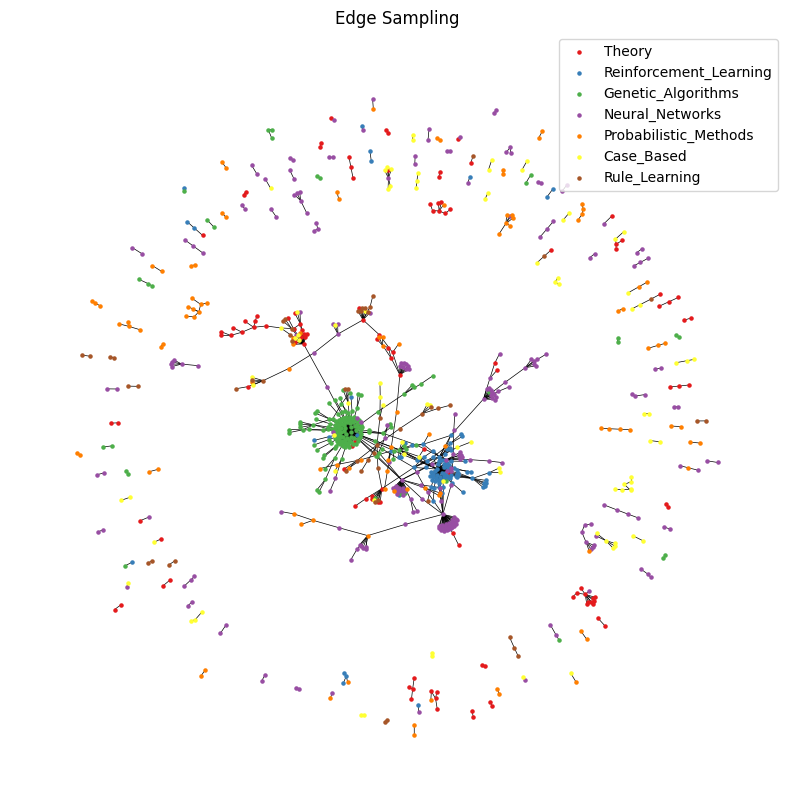

In [169]:
analyze_sampling(es_graph, "Edge Sampling")

## Traversal Based Sampling

This family of methods includes all algorithms that take the topology of the network into account during sampling.

### Breadth/ Depth/ Random First Sampling

Start by sampling a single node $v_0\in V$ and insert it into a queue $Q$ and by setting $V_S = E_S = \emptyset$. At each iteration, until the desired sampling size is reached:
- extract a node $v$ from $Q$;
- update $V_S = V_S \cup \{v\}$ and $E_S=E_S \cup \{(u,v)\}$ where $u$ is the node that added $v$ in $Q$ because $v\in \mathcal{N}(u)$;
- add to $Q$ all the neighbors $u \in \mathcal{N}(v)$ of the extracted node such that $u \notin Q$ and $u \notin V_S$.

Depending on how it is extracted from $Q$ we obtain the following algorithms:
- **BFS**: always extract from top of $Q$;
- **DFS**: always extract from the bottom of $Q$;
- **RFS**: extract randomly.

In [170]:
def search_sampling(graph, extract, num_samples):
  if extract != "BFS" and extract != "DFS" and extract != "RFS":
    raise ValueError("extract must be BFS, DFS or RFS")
  
  degs = degree(graph.edge_index[0], graph.num_nodes)
  sample_nodes_ids = np.array([], dtype=int)
  sample_edges = np.array([], dtype=int)
  visited = np.array([], dtype=int)
  start_id = np.random.choice(graph.num_nodes, 1, replace=False)
  edges_in_queue = np.array([], dtype=int)
  queue = np.array([], dtype=int)
  queue = np.append(queue, start_id)
  while len(sample_nodes_ids) < num_samples:
    if extract == "BFS":
      node_id = queue[0]
      queue = queue[1:]
    elif extract == "DFS":
      node_id = queue[-1]
      queue = queue[:-1]
    elif extract == "RFS":
      curr_degs = degs[queue].numpy()
      probs = curr_degs / np.sum(curr_degs)
      id = np.random.choice(len(queue), 1, p=probs)
      node_id = queue[id].item()
      queue = np.delete(queue, [id])

    neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)
    visited = np.append(visited, node_id)
    for neigh in neighs:
      neigh = neigh.item()
      if neigh not in visited and neigh not in queue:
        queue = np.append(queue, neigh)
        edge = np.array([node_id, neigh])
        edges_in_queue = np.vstack([edges_in_queue, edge]) if edges_in_queue.size else edge
        

    if len(sample_nodes_ids) > 0:
      i = 0
      for edge in edges_in_queue:
        if edge[1] == node_id:
          sample_edges = np.vstack([sample_edges, edge]) if sample_edges.size else edge
          break
        i += 1
      edges_in_queue = np.delete(edges_in_queue, i, axis=0)


    sample_nodes_ids = np.append(sample_nodes_ids, node_id)


  sample_edges = torch.tensor(np.array(sample_edges)).t()
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]

  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [171]:
num_samples_nodes, _ = num_samples(graph, 0.7)
bfs_graph = search_sampling(graph, "BFS", num_samples_nodes)

Number of nodes: 812
Number of node features: 1433
Number of edges: 1622
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.00
Number of classes: 7
Number of connected components: 1
Density: 0.00246
Average clustering coefficient: 0.00000
Transitivity: 0.00000


count  mean   std  min  25%  50%  75%    max
0  812.0   2.0  6.25  1.0  1.0  1.0  1.0  155.0

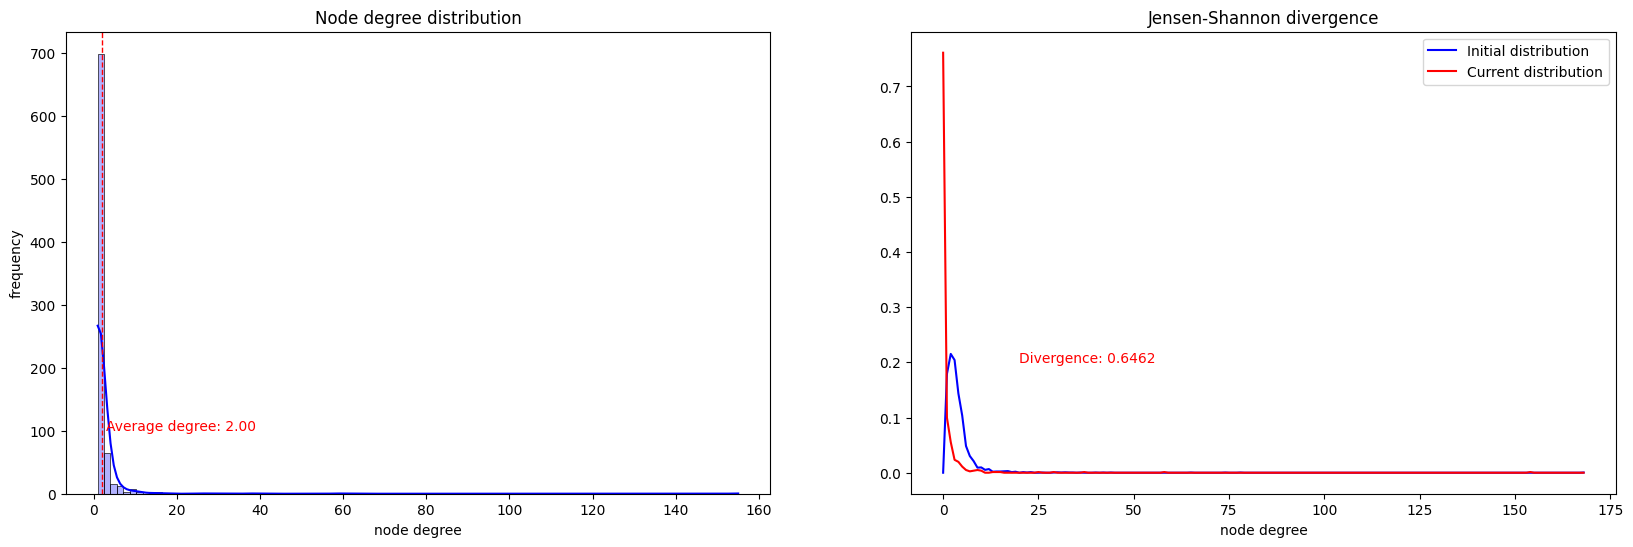

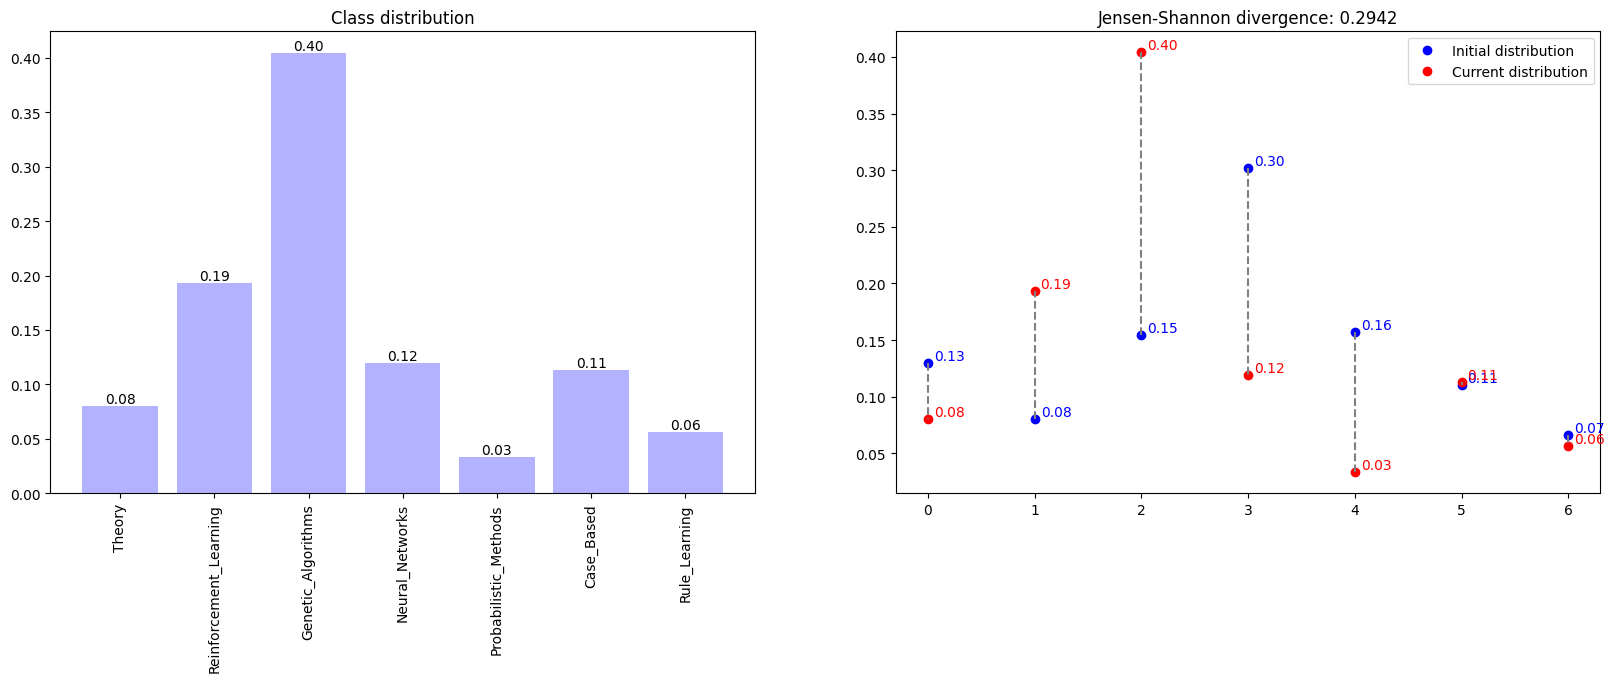

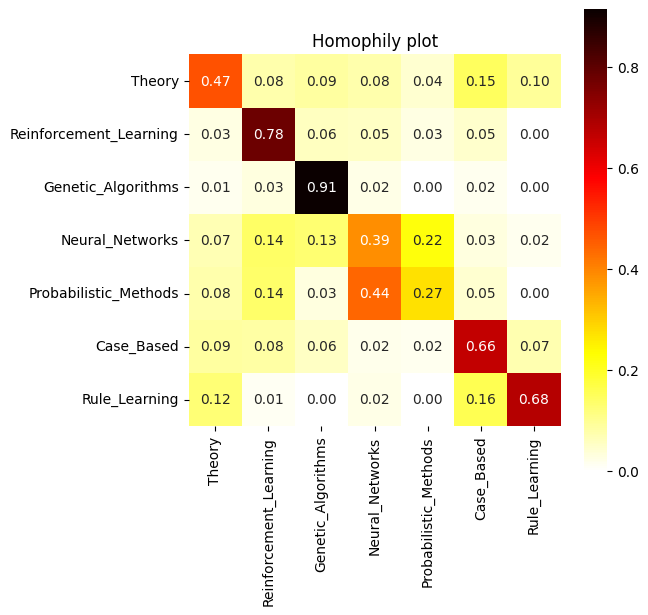

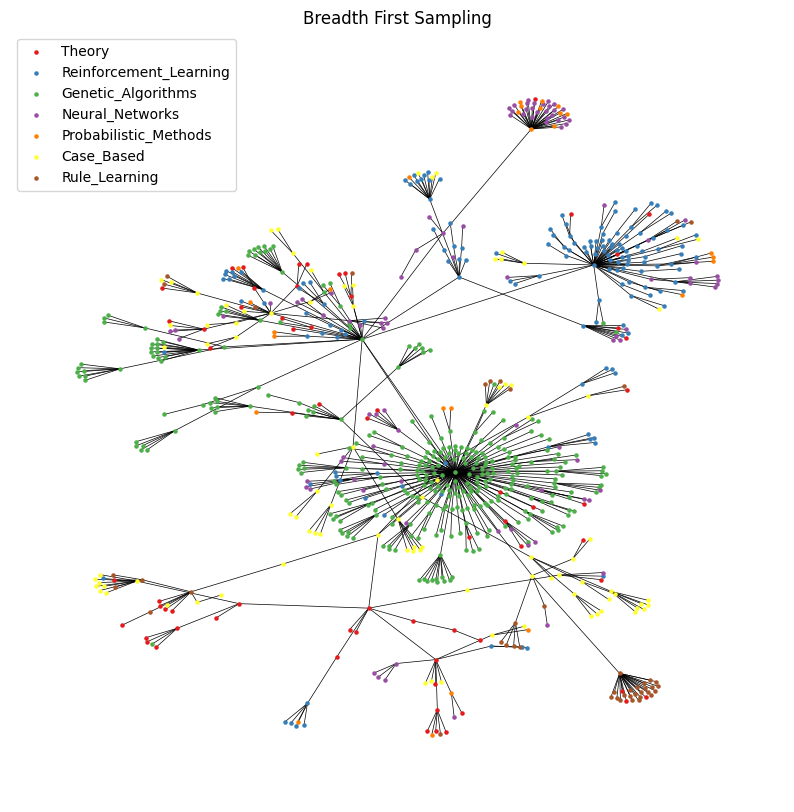

In [172]:
analyze_sampling(bfs_graph, "Breadth First Sampling")

In [173]:
depth_graph = search_sampling(graph, "DFS", num_samples_nodes)

Number of nodes: 812
Number of node features: 1433
Number of edges: 1622
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.00
Number of classes: 7
Number of connected components: 1
Density: 0.00246
Average clustering coefficient: 0.00000
Transitivity: 0.00000


count  mean   std  min  25%  50%  75%  max
0  812.0   2.0  1.13  1.0  1.0  2.0  2.0  7.0

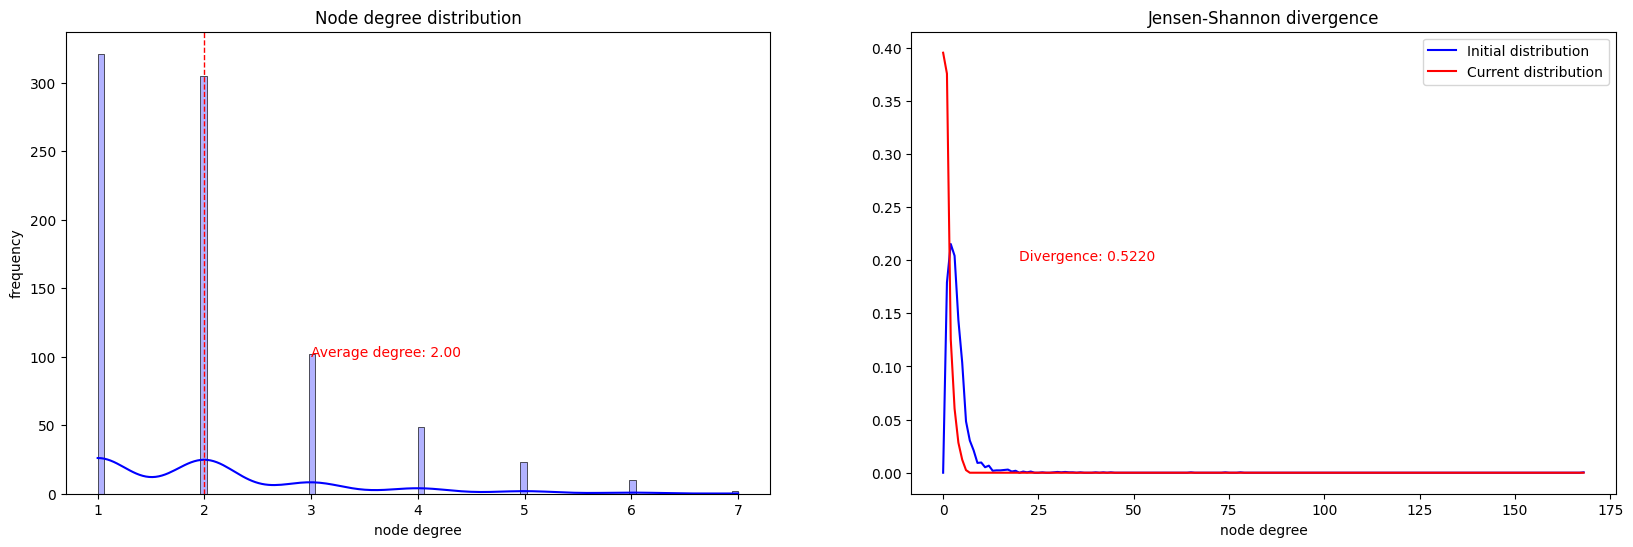

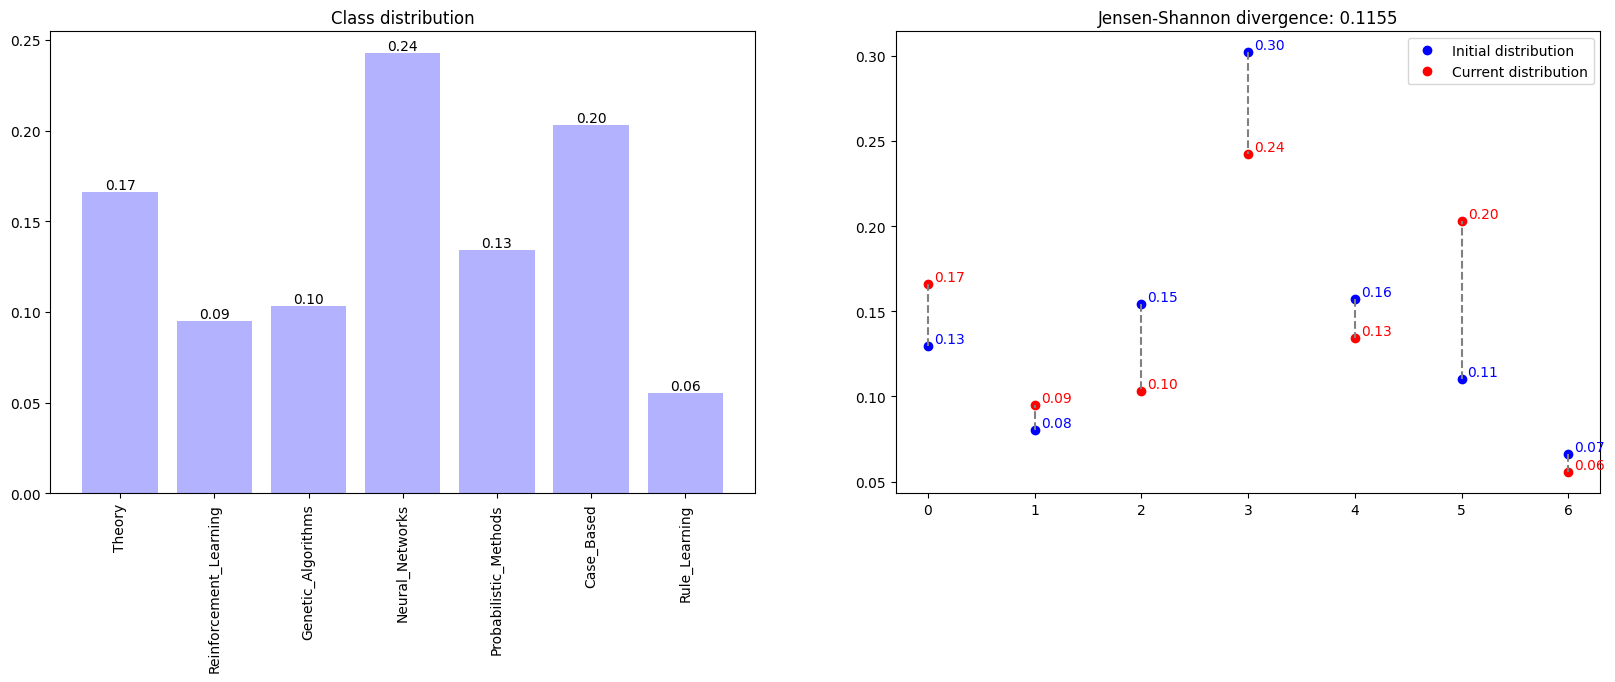

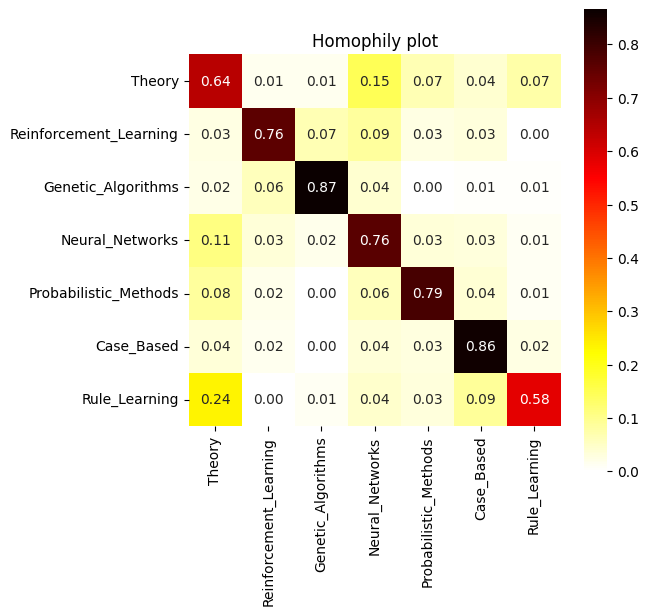

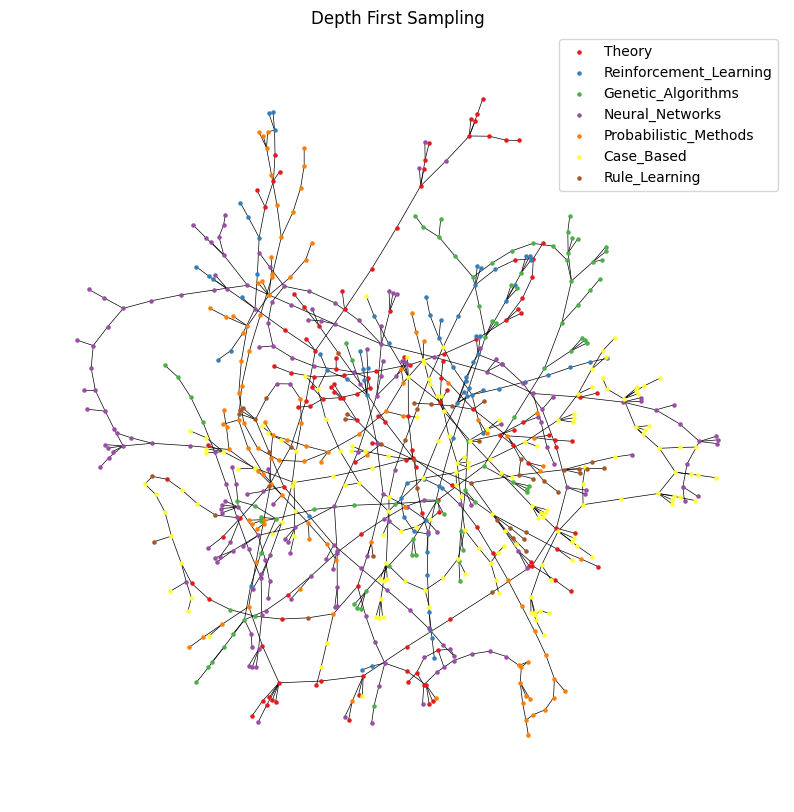

In [174]:
analyze_sampling(depth_graph, "Depth First Sampling")

In [175]:
rfs_graph = search_sampling(graph, "RFS", num_samples_nodes)

Number of nodes: 812
Number of node features: 1433
Number of edges: 1622
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.00
Number of classes: 7
Number of connected components: 1
Density: 0.00246
Average clustering coefficient: 0.00000
Transitivity: 0.00000


count  mean  std  min  25%  50%  75%    max
0  812.0   2.0  4.4  1.0  1.0  1.0  2.0  101.0

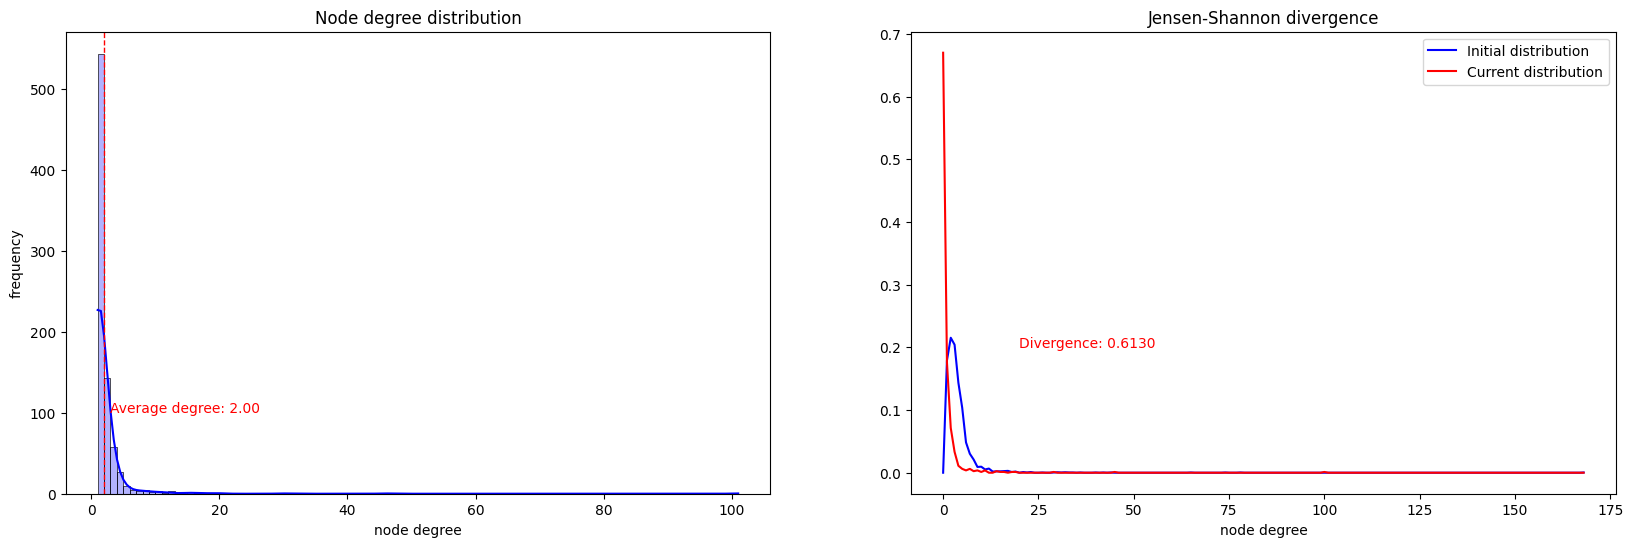

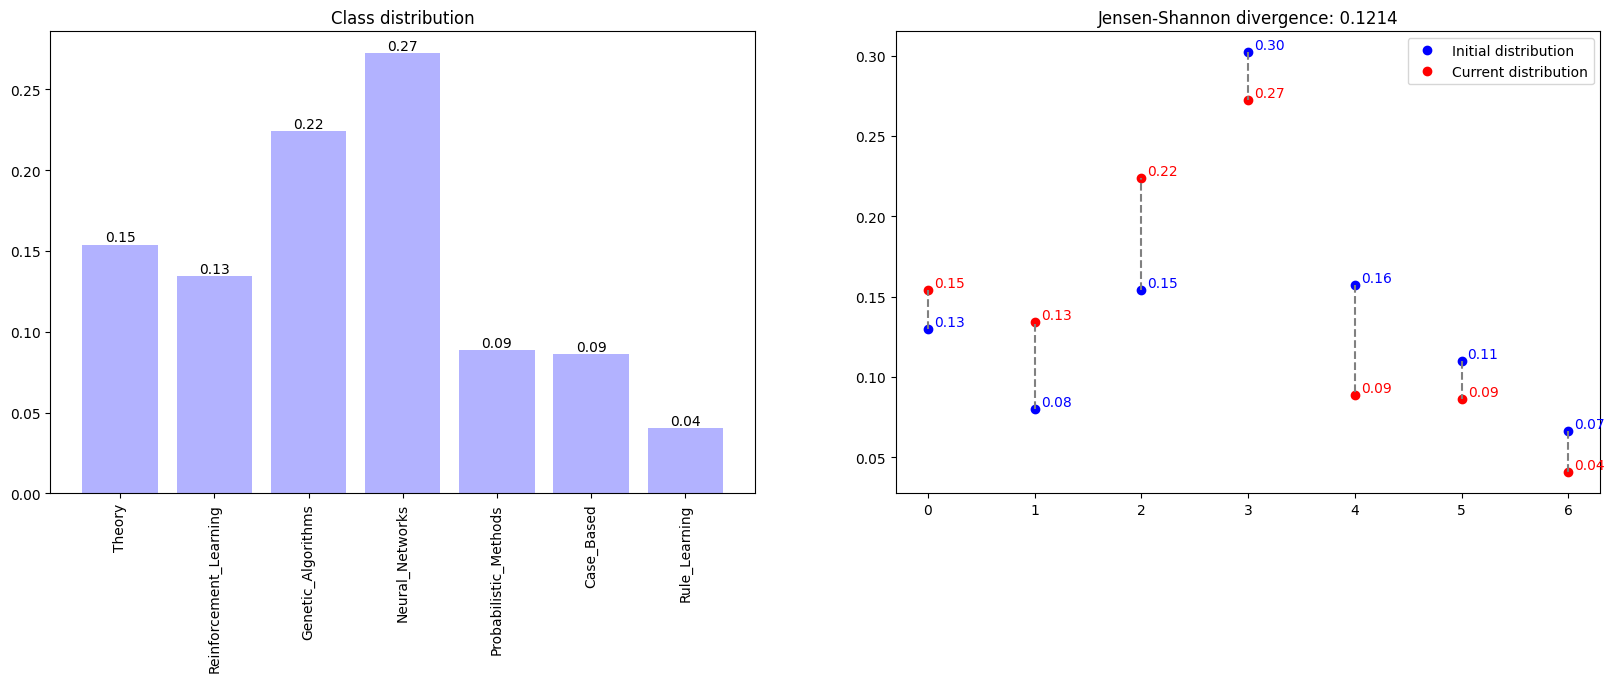

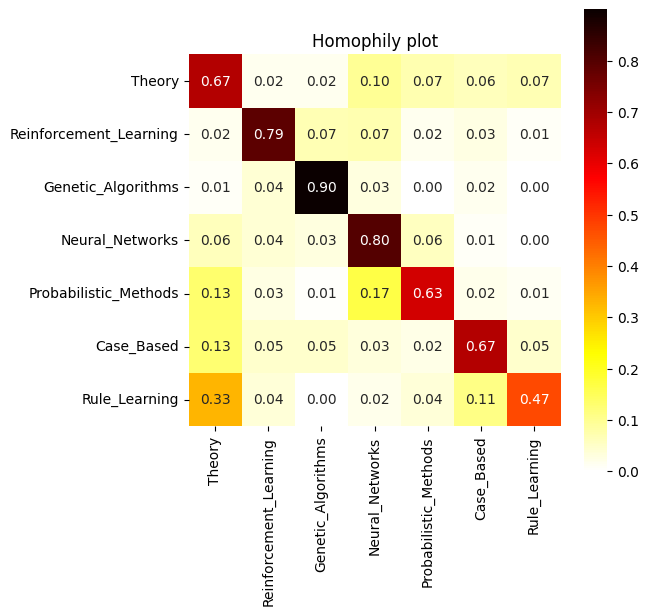

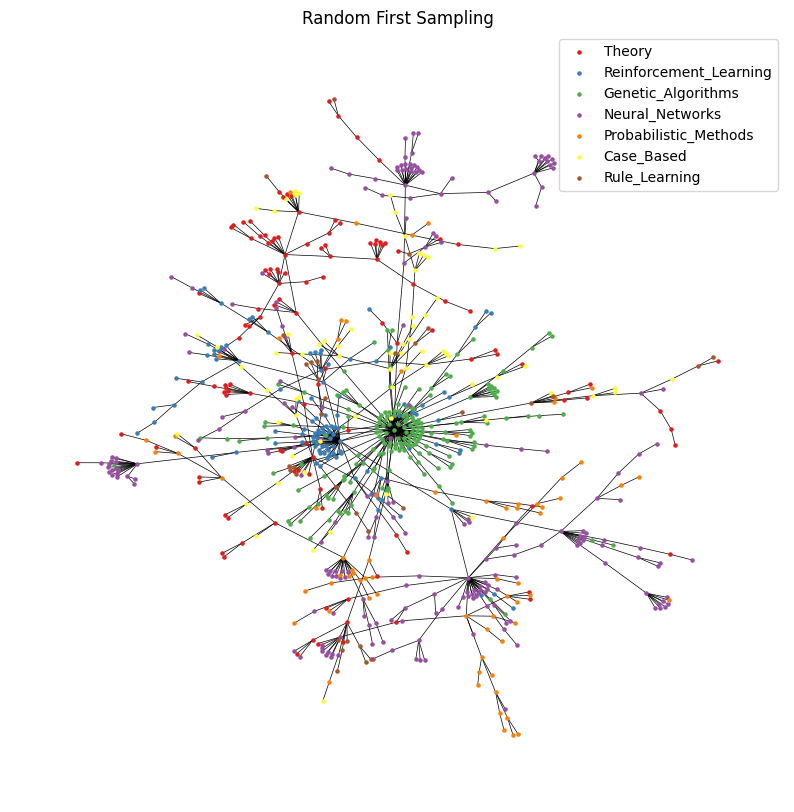

In [176]:
analyze_sampling(rfs_graph, "Random First Sampling")

### Snow-Ball Sampling (SBS)

The sampling algorithm is as follows:
- Start from an initial set of nodes $V^{(0)}$ obtained through expert knowledge or from a sampling on $V$;
- At each iteration $i$:
  - get $k$ new neighbors from each node in $V^{(i-1)}$ and define with $E^{(i)}$ the set of edges used;
  - create the set $\tilde{V}^{(i)}$ composed of all nodes in $V^{(i-1)}$ and all $k$ neighbors sampled for each node;
  - update $V^{(i)} = \tilde{V}^{(i)} - \bigcup_{j=0}^{i-1} V^{(j)}$
- Once the maximum number of iterations $T$ is reached, return $G_S=(V_S, E_S)$ with $V_S= \bigcup_{t=0}^T V^{(t)}$ and $E_S= \bigcup_{t=0 }^T E^{(t)}$.

In [177]:
def snow_ball_sampling(graph, start_dim, num_iter, k):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, start_dim, replace=False, p=probs)
  all_nodes = set()
  v = set()
  v.update(node_samp_ids.flatten())
  all_nodes.update(v)
  all_edges = []

  for _ in range(num_iter):

    v_tilde = set()
    v_tilde.update(v)
    all_neighs = set()

    for node_id in v:
      neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)

      mask = neighs != node_id
      neighs = neighs[mask]
      
      if(len(neighs) > k):
        neighs_deg = degs[neighs].numpy()
        probs = neighs_deg / np.sum(neighs_deg)
        neighs = np.random.choice(neighs, k, replace=False, p=probs)
      
      all_neighs.update(neighs.flatten())

      for n in neighs:
        n = n.item()
        all_edges.append([node_id, n])

    v_tilde.update(all_neighs)
    v = v_tilde - all_nodes
    all_nodes.update(v)

  sample_edges = torch.tensor(np.array(all_edges)).t()
  sample_edges = coalesce(sample_edges)
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes_ids = sample_edges.t()[:,0:1].unique().squeeze()
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]
  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [178]:
sbs_graph = snow_ball_sampling(graph, 30, 5, 3)

Number of nodes: 969
Number of node features: 1433
Number of edges: 3160
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.26
Number of classes: 7
Number of connected components: 3
Density: 0.00337
Average clustering coefficient: 0.15099
Transitivity: 0.10672


count  mean   std  min  25%  50%  75%   max
0  969.0  3.26  3.21  1.0  1.0  3.0  4.0  57.0

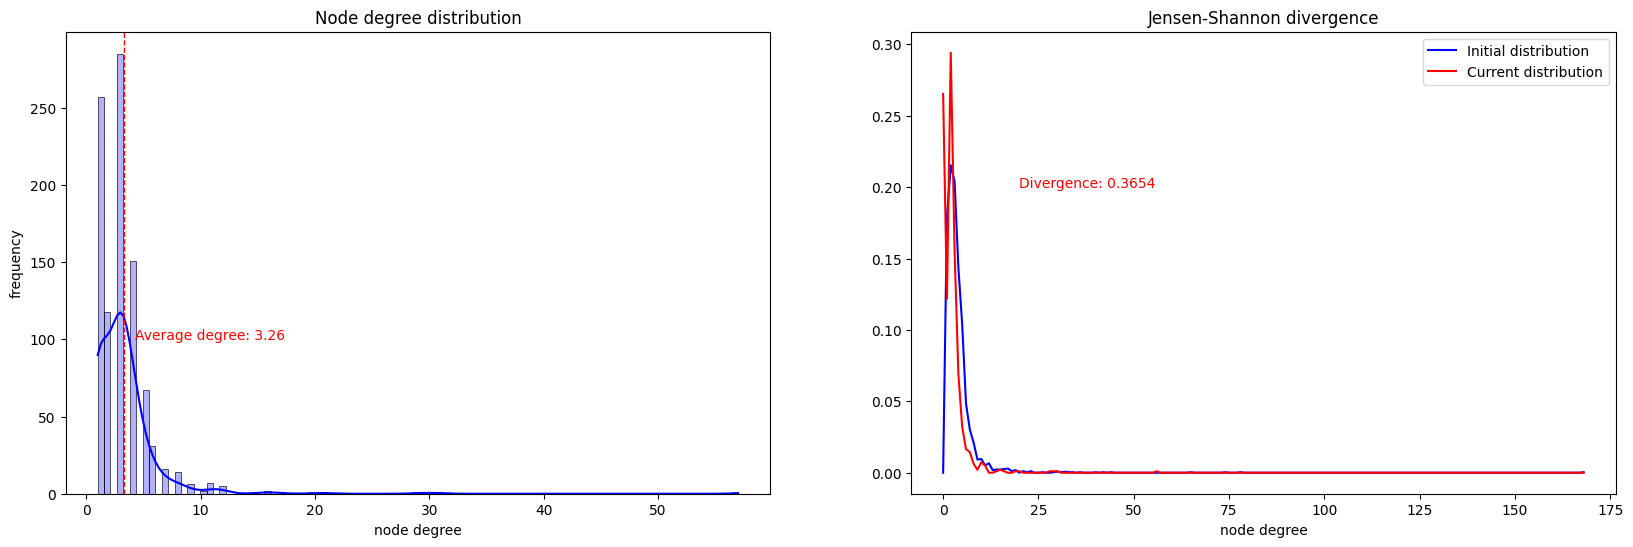

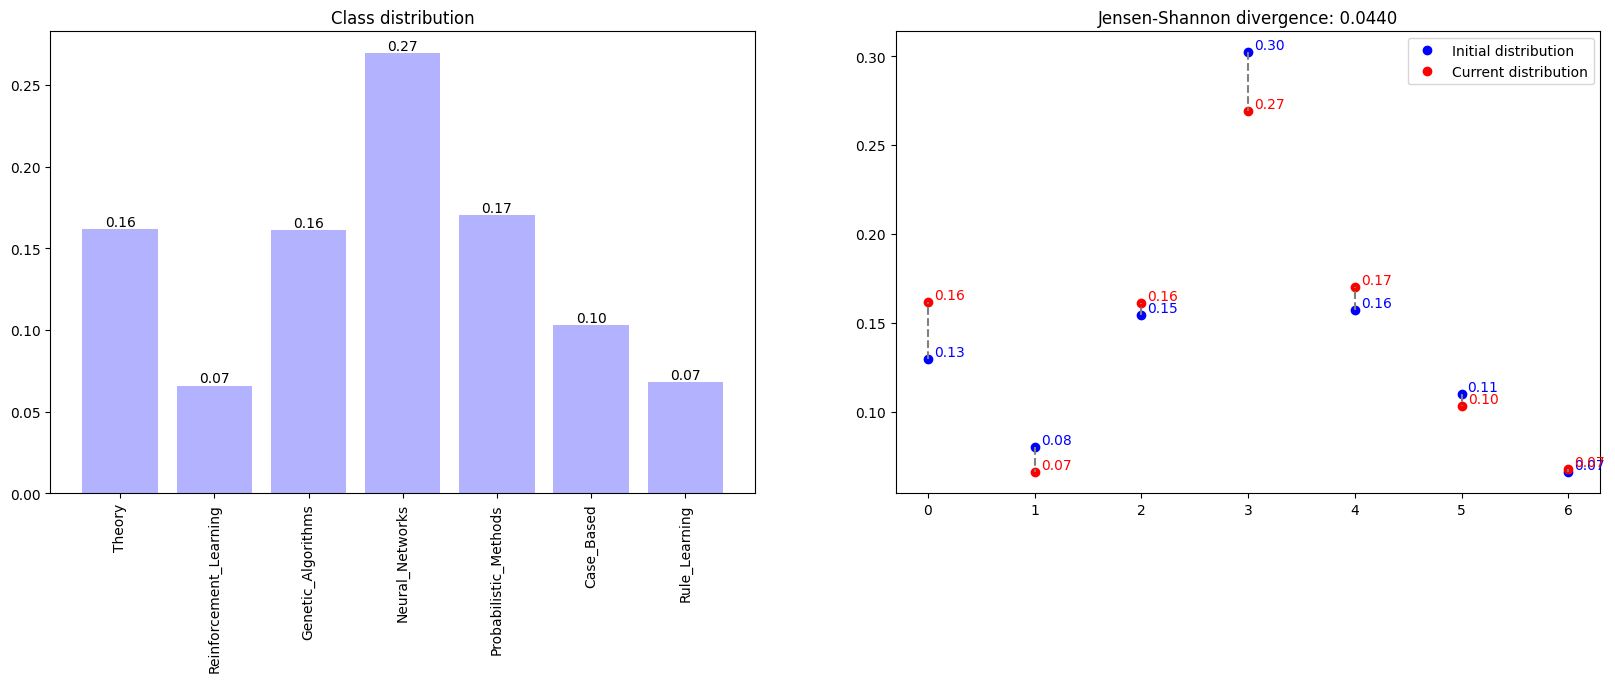

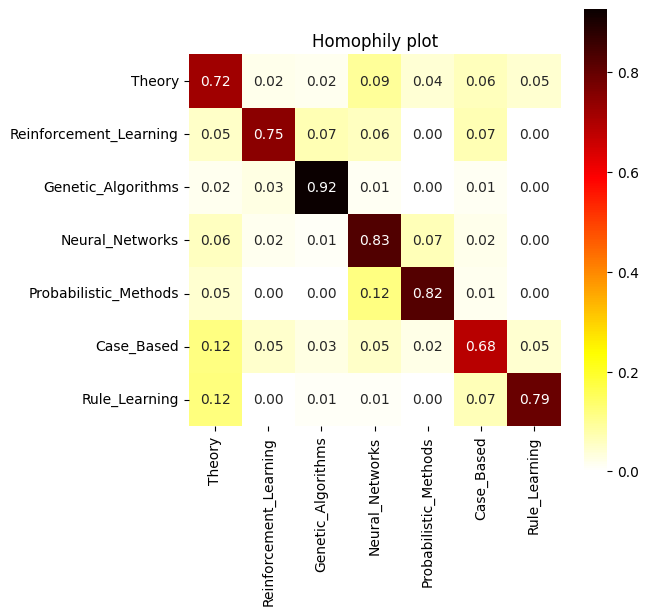

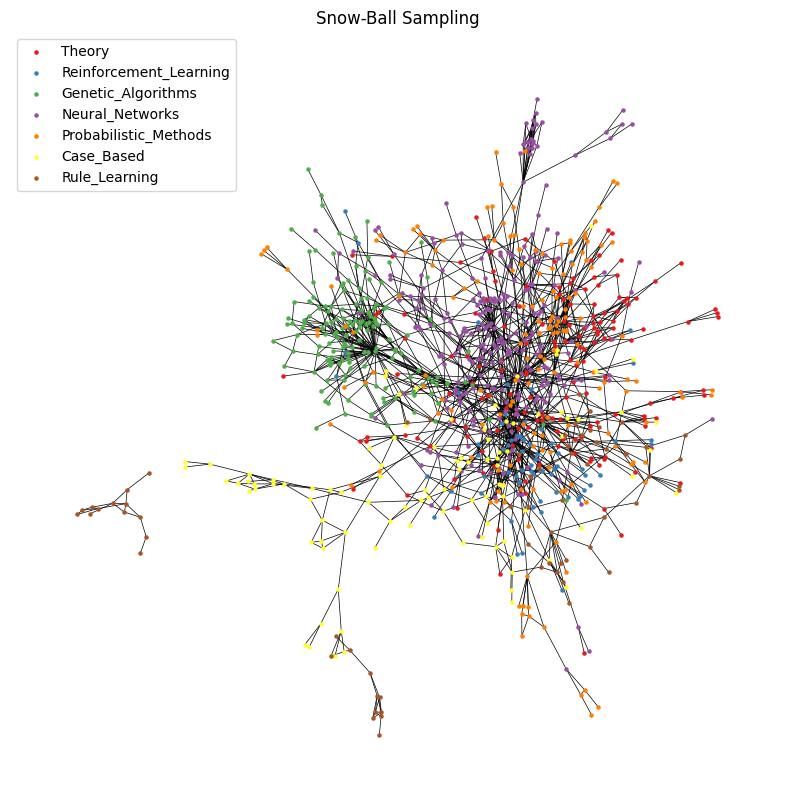

In [179]:
analyze_sampling(sbs_graph, "Snow-Ball Sampling")

### Forest Fire Sampling (FFS)

It is like Snow-Ball Sampling with the only difference that the number $k$ of neighbors to sample from each node at each iteration is not a fixed number, but is generated according to $K \sim \texttt{Geometric} (p)$. If $p=\frac{1}{k}$ then we have that $\mathbb{E}[K]=k$ the two techniques coincide on average.

In [180]:
def forest_fire_sampling(graph, start_dim, num_iter, p):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, start_dim, replace=False, p=probs)
  all_nodes = set()
  v = set()
  v.update(node_samp_ids.flatten())
  all_nodes.update(v)
  all_edges = []

  for _ in range(num_iter):

    v_tilde = set()
    v_tilde.update(v)
    all_neighs = set()


    for node_id in v:
      neighs, _, _, _  = k_hop_subgraph(torch.tensor([node_id]),
                                                     1,
                                                     graph.edge_index)

      k = np.random.geometric(p)
      
      mask = neighs != node_id
      neighs = neighs[mask]
      
      if(len(neighs) > k):
        neighs_deg = degs[neighs].numpy()
        probs = neighs_deg / np.sum(neighs_deg)
        neighs = np.random.choice(neighs, k, replace=False, p=probs)
      
      all_neighs.update(neighs.flatten())

      for n in neighs:
        n = n.item()
        all_edges.append([node_id, n])


    v_tilde.update(all_neighs)
    v = v_tilde - all_nodes
    all_nodes.update(v)

  sample_edges = torch.tensor(np.array(all_edges)).t()
  sample_edges = coalesce(sample_edges)
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes_ids = sample_edges.t()[:,0:1].unique().squeeze()
  sample_nodes = graph.x[sample_nodes_ids]
  sample_y = graph.y[sample_nodes_ids]
  relabeled_edge_index = relabel_edge_index(sample_nodes_ids, sample_edges)

  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  return sample_graph

In [181]:
ffs_graph = forest_fire_sampling(graph, 30, 6, p=0.33)

Number of nodes: 1034
Number of node features: 1433
Number of edges: 3546
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.43
Number of classes: 7
Number of connected components: 2
Density: 0.00332
Average clustering coefficient: 0.18243
Transitivity: 0.11374


count  mean   std  min  25%  50%  75%   max
0  1034.0  3.43  3.53  1.0  2.0  3.0  4.0  55.0

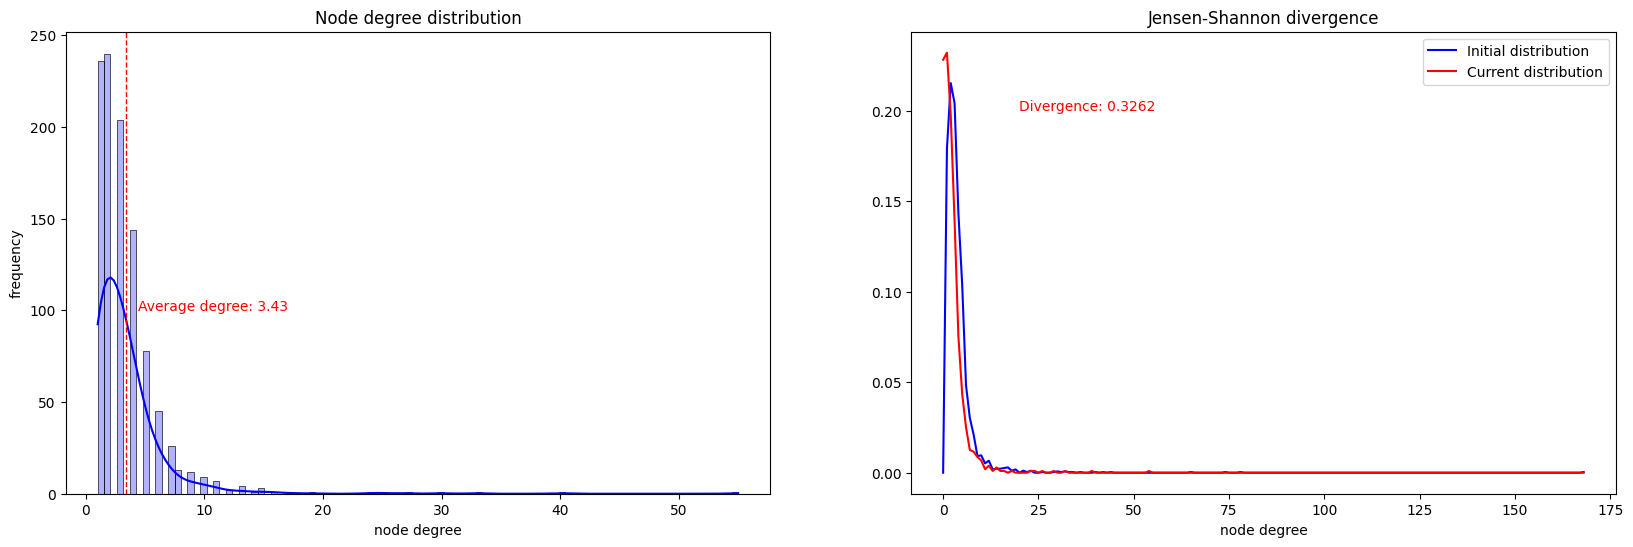

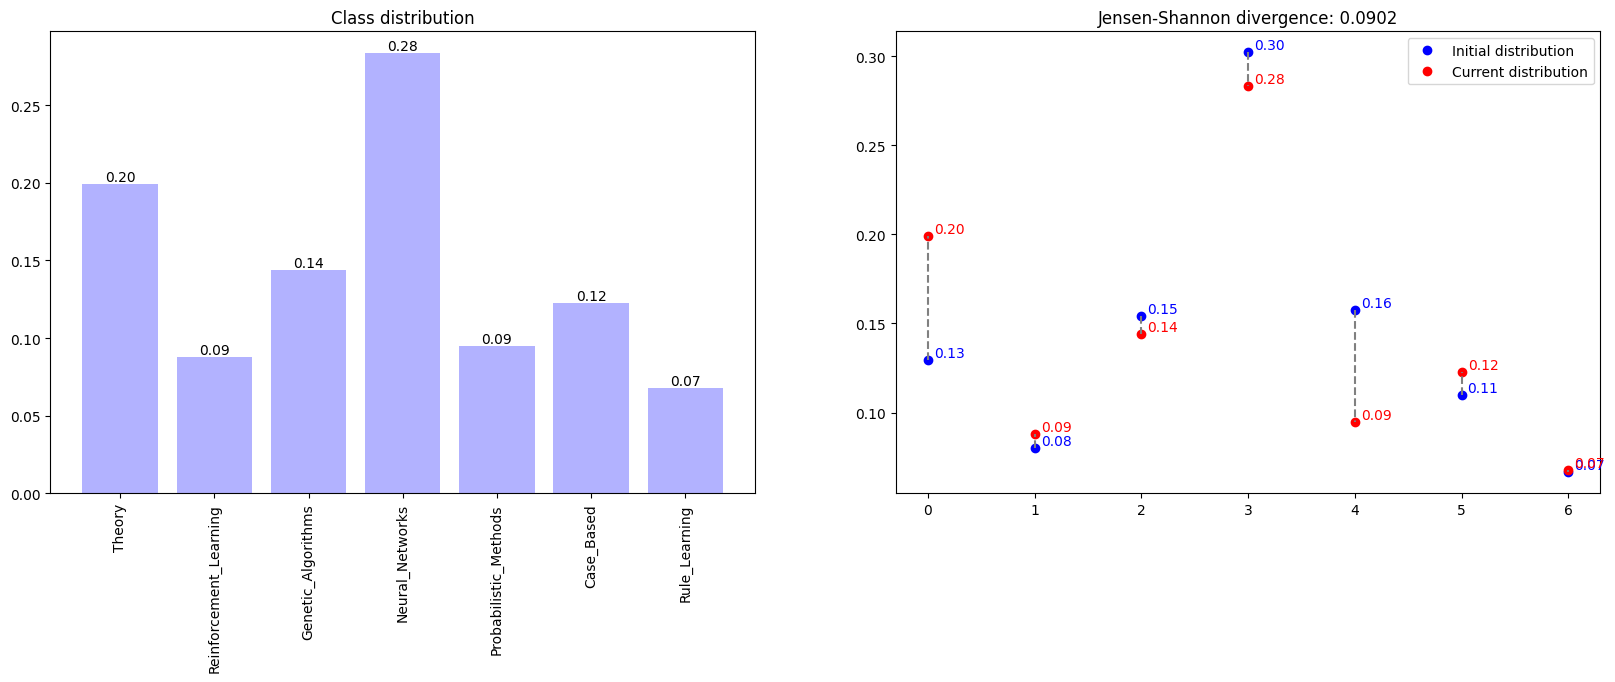

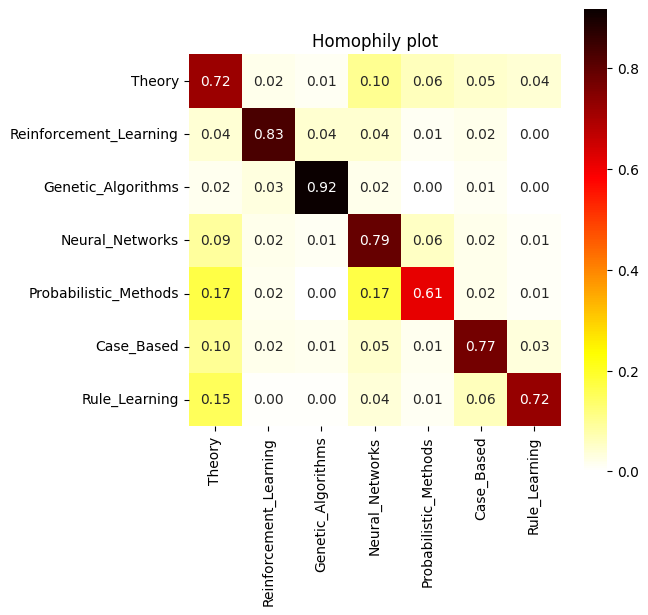

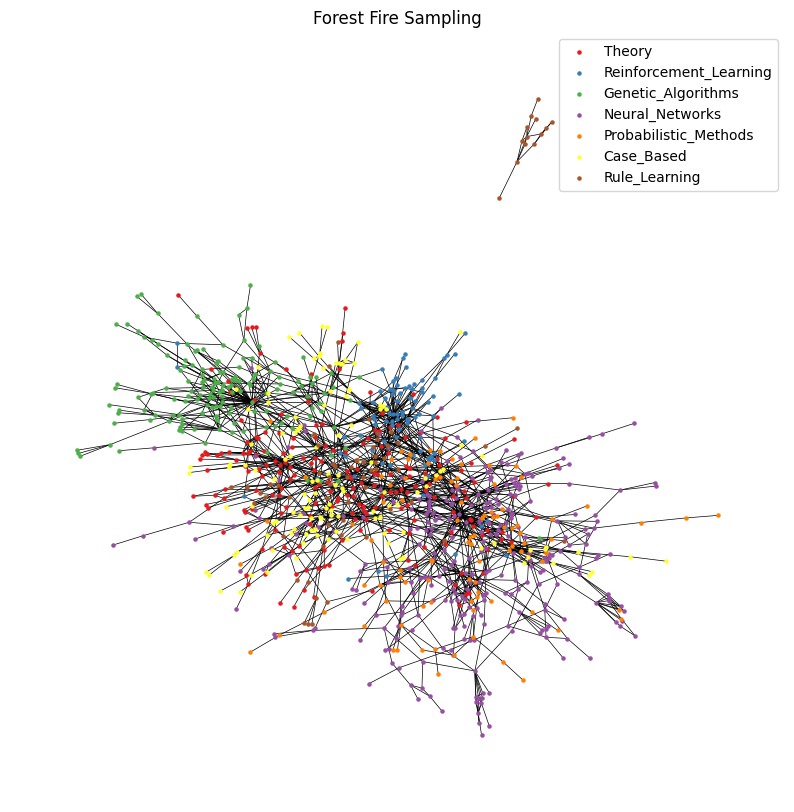

In [182]:
analyze_sampling(ffs_graph, "Forest Fire Sampling")

### Random Walk

Start from a random node $v_0 \in V$, insert it into $V_S$, and at each step, until a certain termination condition is reached:
- samples uniformly (or according to some distribution) the next node among the neighbors $v_j \in \mathcal{N}(v_i)$ of the current node $v_i$;
- add $v_j \in V_S$;
- add the edge $(v_i, v_j)\in E_S$

Return $G_S=(V_S, E_S)$.

In [183]:
def random_walk_sampling(graph, num_samples, force, start=None, relabel=True):

  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  
  if start is None:
    curr_id = np.random.choice(graph.num_nodes, 1, replace=False, p=probs)
    curr_id = curr_id.item()
  else:
    curr_id = start

  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0
  max_it_before_exit = 10000
  
  while len(node_ids) < num_samples and n_it < max_it_before_exit:
    n_it += 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    mask = neighs != curr_id
    neighs = neighs[mask]
    neighs_deg = degs[neighs].numpy()
    probs = neighs_deg / np.sum(neighs_deg)
    new_id = np.random.choice(neighs, 1, replace=False, p = probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
      
    curr_id = new_id


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  
  if relabel:
    relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
    sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  else:
    sample_graph = Data(x=sample_nodes, edge_index=sample_edges, y=sample_y)
    
  if n_it >= max_it_before_exit:
    print("Max iterations reached. Exiting because stucked")

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", len(edges), " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")

  return sample_graph, node_dist_dict

In [184]:
num_samples_nodes, _ = num_samples(graph, 0.7)
rw_graph, node_dist_dict = random_walk_sampling(graph, num_samples_nodes, True)

2928 iterations required to explore  812  different nodes


Number of nodes: 812
Number of node features: 1433
Number of edges: 2426
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.99
Number of classes: 7
Number of connected components: 1
Density: 0.00368
Average clustering coefficient: 0.16530
Transitivity: 0.03079


count  mean   std  min  25%  50%  75%    max
0  812.0  2.99  6.51  1.0  1.0  2.0  3.0  151.0

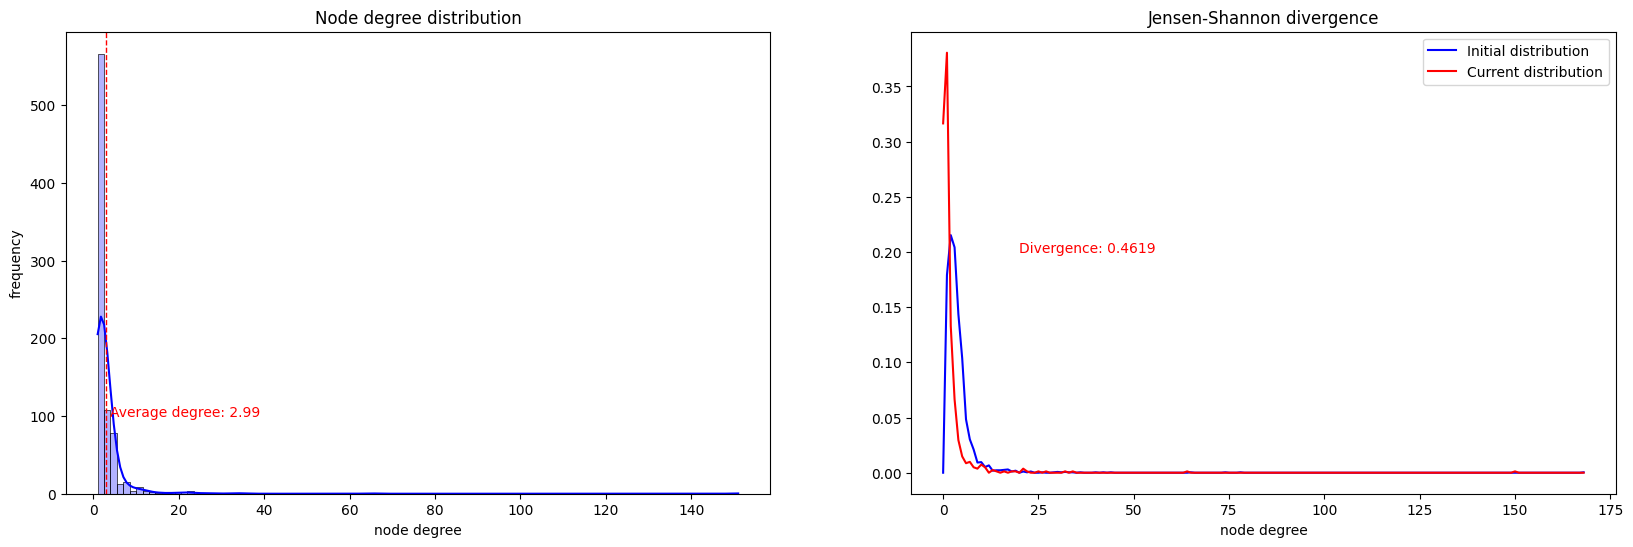

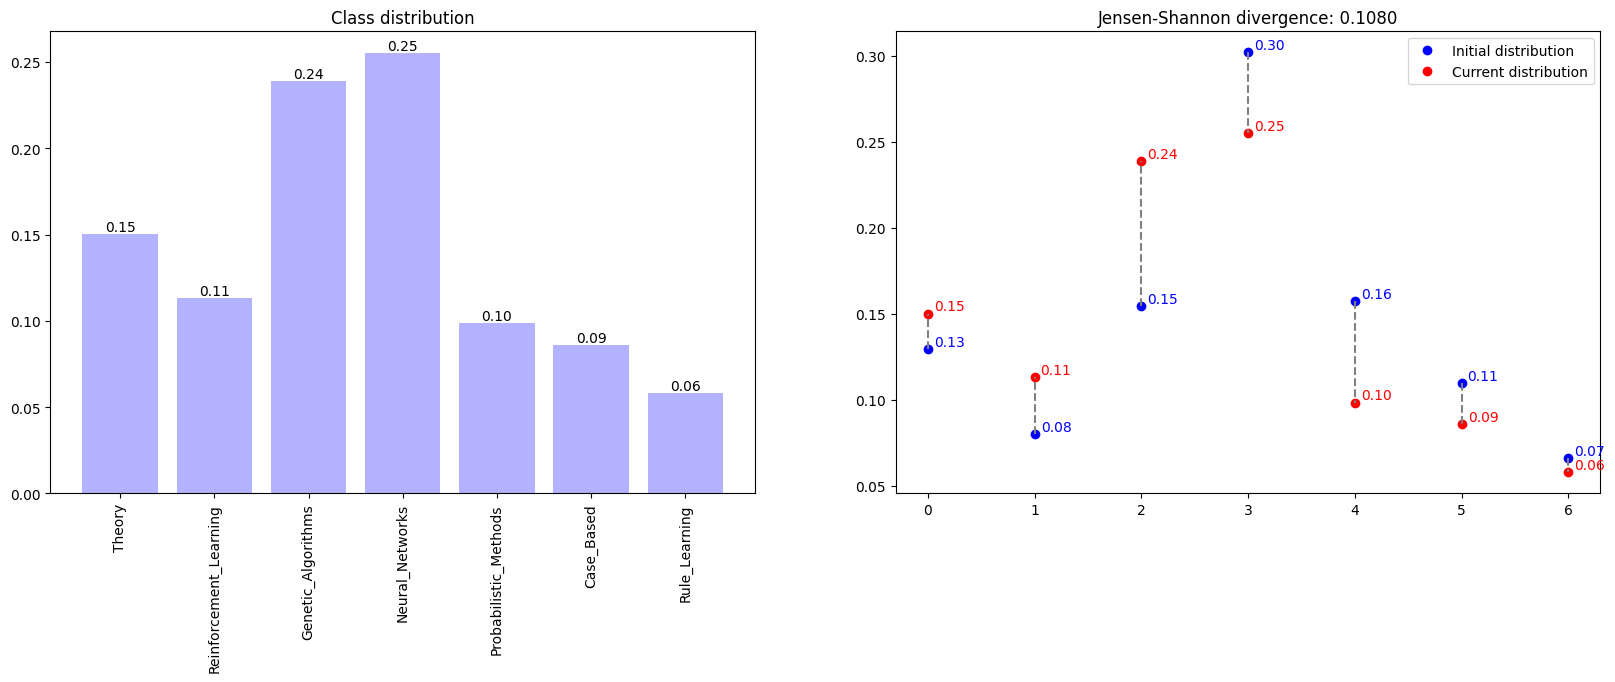

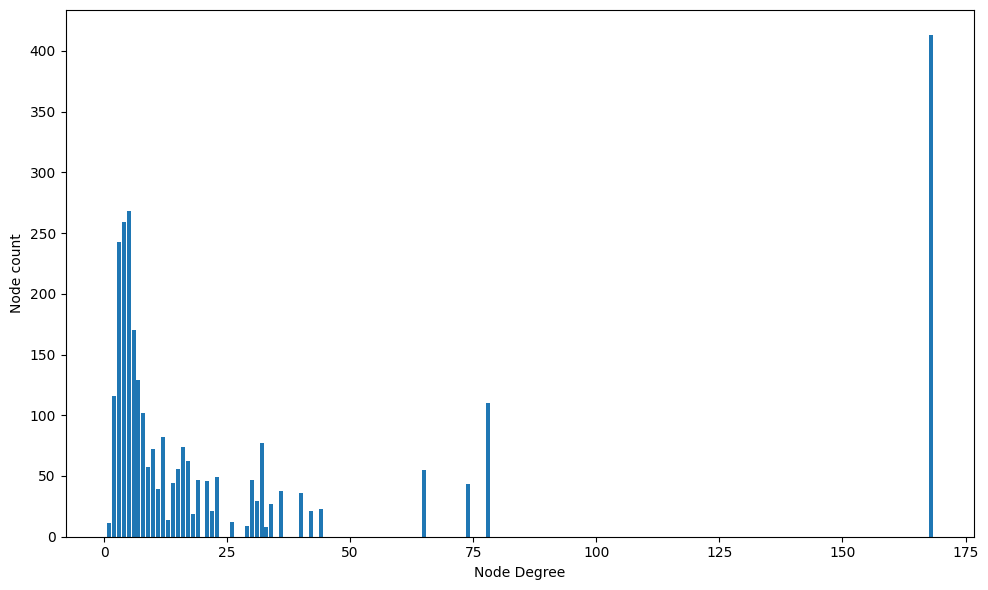

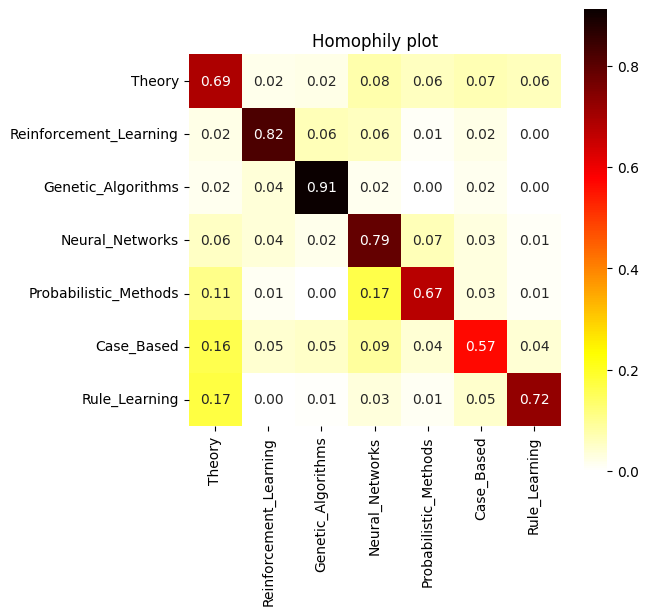

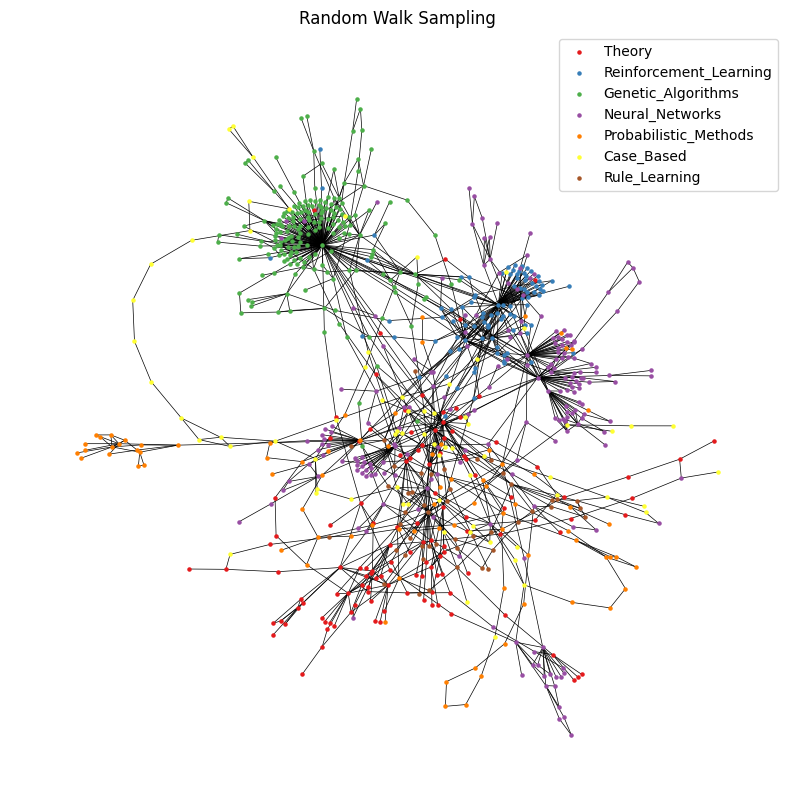

In [185]:
analyze_sampling(rw_graph, "Random Walk Sampling", node_dist_dict)

### Random Walk with Escaping (RWE)

It is a random walk in which there is a non-zero probability of jumping to any non-nearby node. This idea was proposed in Pagerank to make the chain aperiodic and irreducible.

In [186]:
def random_walk_sampling_escaping(graph, num_samples, force, escape_prob):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  curr_id = np.random.choice(graph.num_nodes, 1, replace=False, p=probs)
  curr_id = curr_id.item()
  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it += 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    neighs_deg = degs[neighs].numpy()
    curr_pos = np.where(neighs == curr_id)[0].item()
    neighs_deg[curr_pos] = 0
    
    escape_id = -1
    
    while escape_id == -1:
      escape_id = np.random.choice(graph.num_nodes, 1, replace=False).item()
      if escape_id in neighs:
        escape_id = -1
    
    neighs[curr_pos] = escape_id
    probs = np.zeros_like(neighs_deg)
    probs = neighs_deg / np.sum(neighs_deg)
    probs = probs - (escape_prob / (len(neighs) -1))
    # truncate negative values
    probs[probs < 0] = 0
    probs[curr_pos] = escape_prob
    probs = probs / np.sum(probs)
    new_id = np.random.choice(neighs, 1, replace=False, p = probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    curr_id = new_id


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", len(edges), " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")

  return sample_graph, node_dist_dict


In [202]:
rwe_sampling, node_dist_dict = random_walk_sampling_escaping(graph, num_samples_nodes, force=True, escape_prob=0.2)

1556 iterations required to explore  812  different nodes


Number of nodes: 812
Number of node features: 1433
Number of edges: 2204
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.71
Number of classes: 7
Number of connected components: 1
Density: 0.00335
Average clustering coefficient: 0.05829
Transitivity: 0.01998


count  mean   std  min  25%  50%  75%   max
0  812.0  2.71  3.82  1.0  2.0  2.0  3.0  79.0

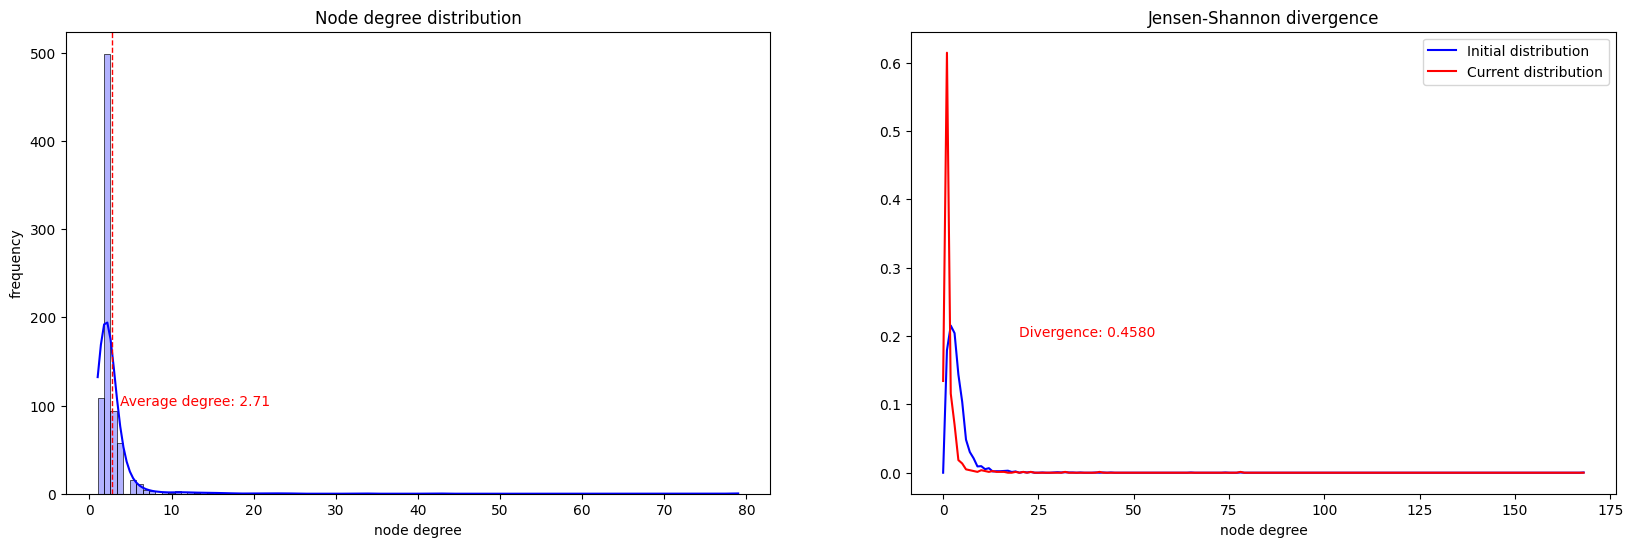

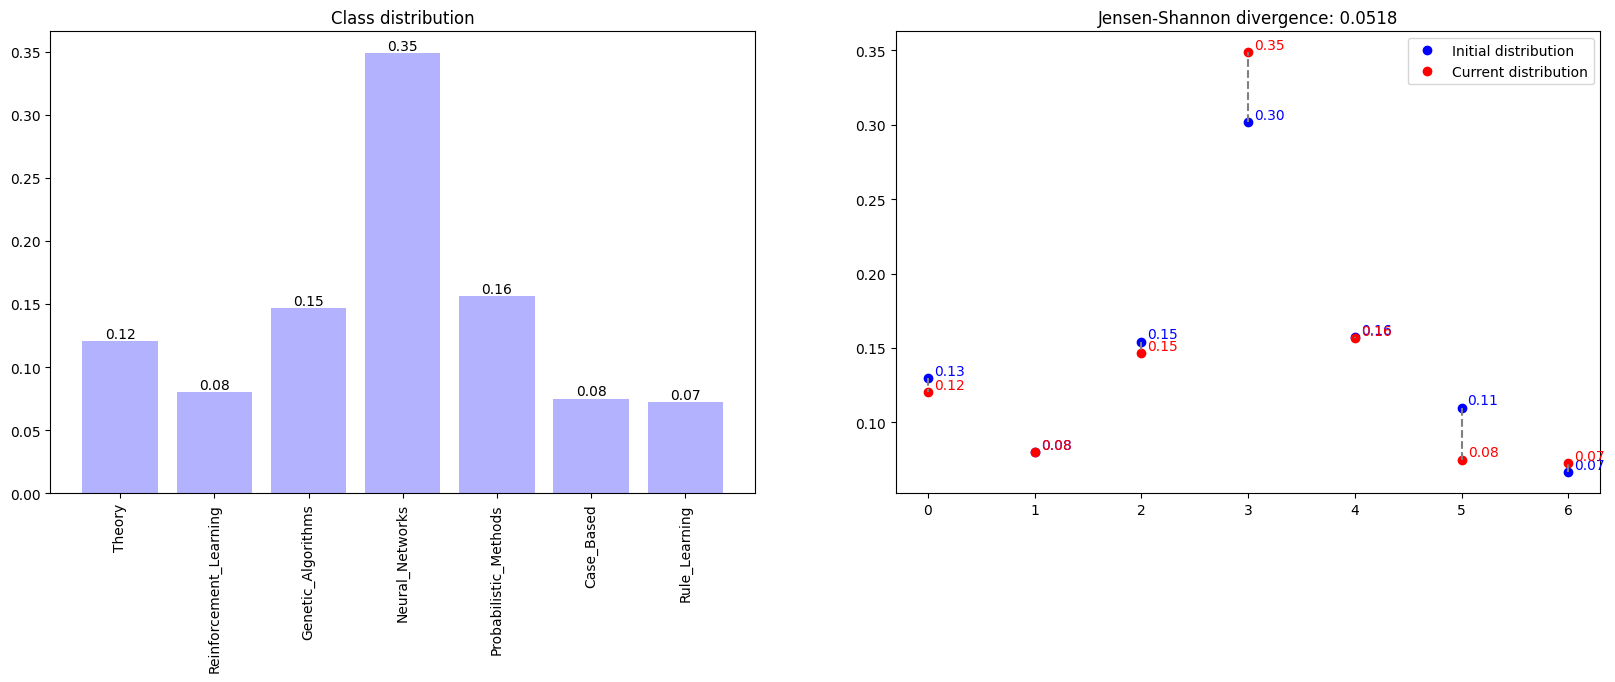

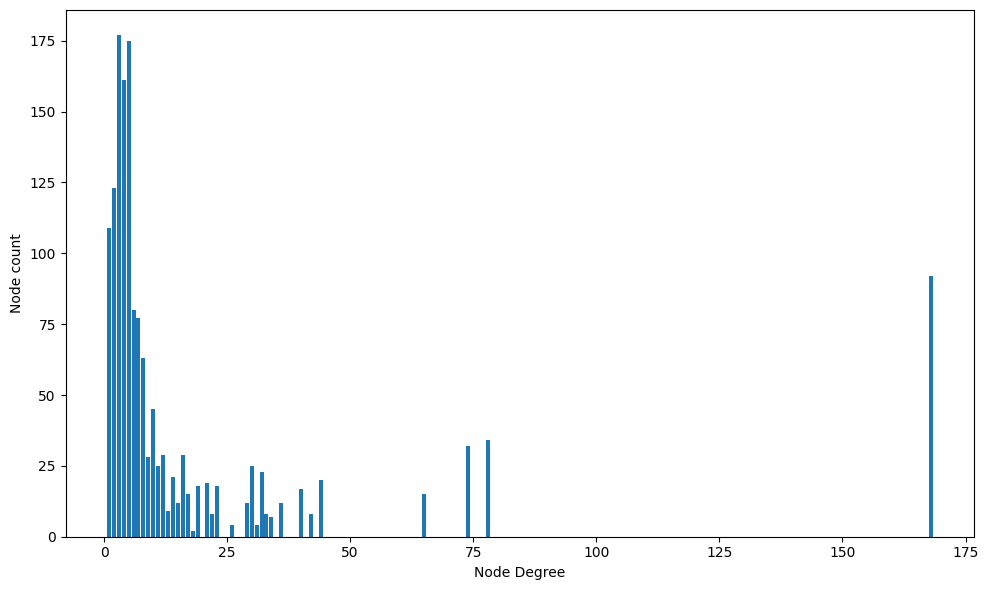

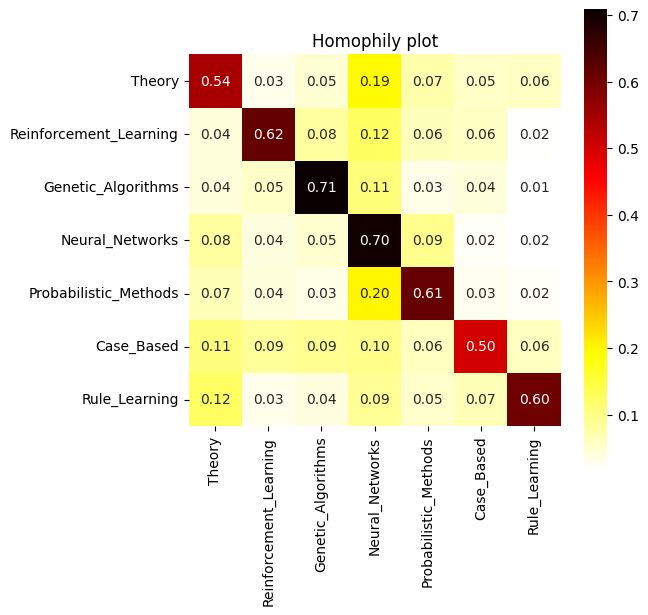

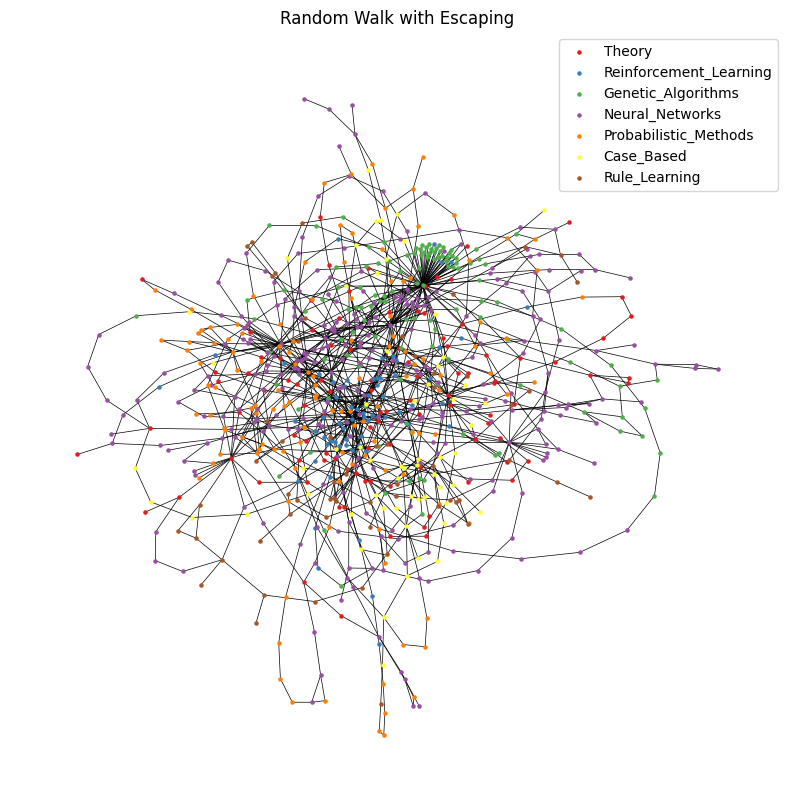

In [203]:
analyze_sampling(rwe_sampling, "Random Walk with Escaping", node_dist_dict)

### Multiple Independent Random Walkers (MIRW)

It's simply a set of different random walks. To explore different areas of the graph, $l$ different starting points are defined and $l$ independent random walks are performed, the set of all edges and nodes obtained are returned.

In [189]:
def multiple_independent_random_walkers(graph, num_samples, num_random_walks, force):
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_random_walks, replace=False, p=probs)

  all_node_dist_dict = None
  all_sample_graph = Data(x=None, edge_index=None, y=None)
  num_samples_walk = int(num_samples / num_random_walks)

  for i in range(num_random_walks):
    curr_id = node_samp_ids[i]
    sample_graph, node_dist_dict = random_walk_sampling(graph, num_samples_walk, force, start=curr_id, relabel=False)

    if all_node_dist_dict is None:
      all_sample_graph = sample_graph
      all_node_dist_dict = node_dist_dict
    else:
      new_edge_index = torch.cat((all_sample_graph.edge_index, sample_graph.edge_index), dim=1)
      new_edge_index, _ = remove_self_loops(new_edge_index)
      new_edge_index = to_undirected(new_edge_index)
      node_ids = new_edge_index.t()[:,0:1].unique().squeeze()
      all_sample_graph.edge_index = new_edge_index
      all_sample_graph.x = graph.x[node_ids]
      all_sample_graph.y = graph.y[node_ids]

      for k, v in node_dist_dict.items():
        if k in all_node_dist_dict:
          all_node_dist_dict[k] += v
        else:
          all_node_dist_dict[k] = v


  node_ids = all_sample_graph.edge_index.t()[:,0:1].unique().squeeze()
  relabeled_edge_index = relabel_edge_index(node_ids, all_sample_graph.edge_index)
  all_sample_graph = Data(x=all_sample_graph.x, edge_index=relabeled_edge_index, y=all_sample_graph.y)

  return all_sample_graph, all_node_dist_dict


In [221]:
num_samples_nodes, _ = num_samples(graph, 0.5)
mirw_graph, node_dist_dict = multiple_independent_random_walkers(graph, num_samples_nodes, 10, force=True)

254 iterations required to explore  135  different nodes
318 iterations required to explore  135  different nodes
282 iterations required to explore  135  different nodes
295 iterations required to explore  135  different nodes
309 iterations required to explore  135  different nodes
244 iterations required to explore  135  different nodes
284 iterations required to explore  135  different nodes
280 iterations required to explore  135  different nodes
289 iterations required to explore  135  different nodes
272 iterations required to explore  135  different nodes


Number of nodes: 737
Number of node features: 1433
Number of edges: 2200
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.99
Number of classes: 7
Number of connected components: 1
Density: 0.00406
Average clustering coefficient: 0.18414
Transitivity: 0.03166


count  mean   std  min  25%  50%  75%    max
0  737.0  2.99  6.73  1.0  1.0  2.0  3.0  147.0

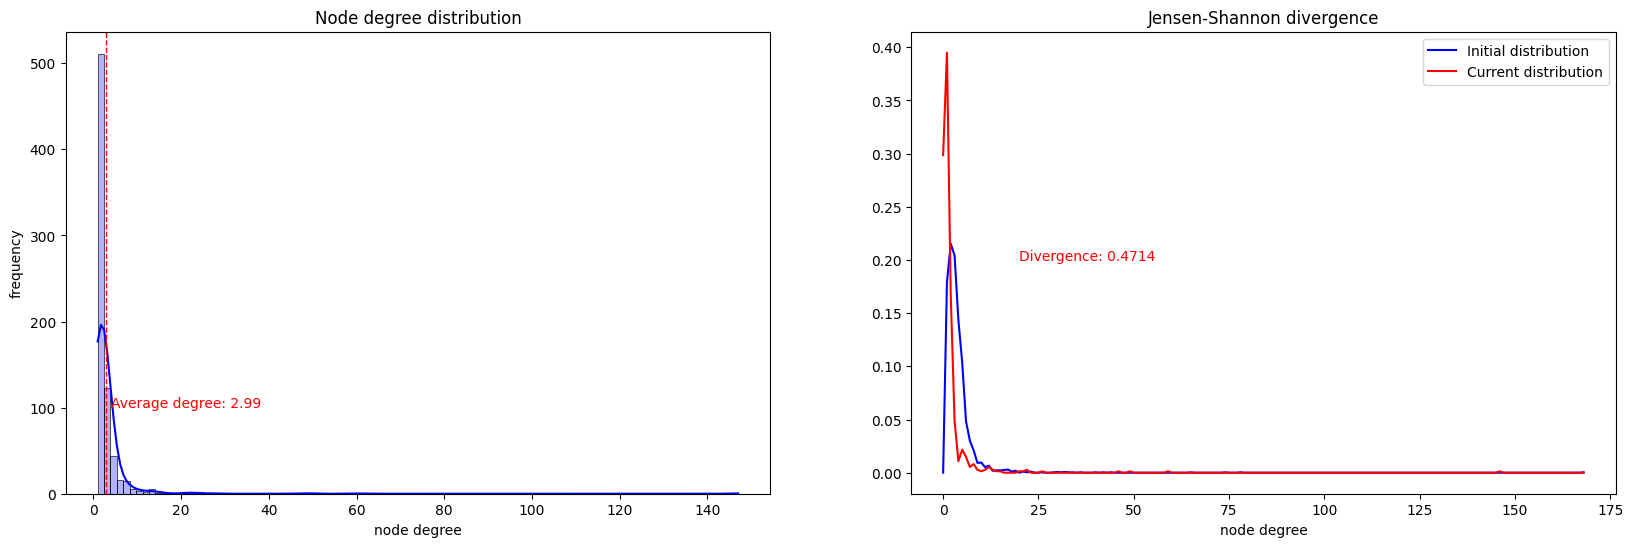

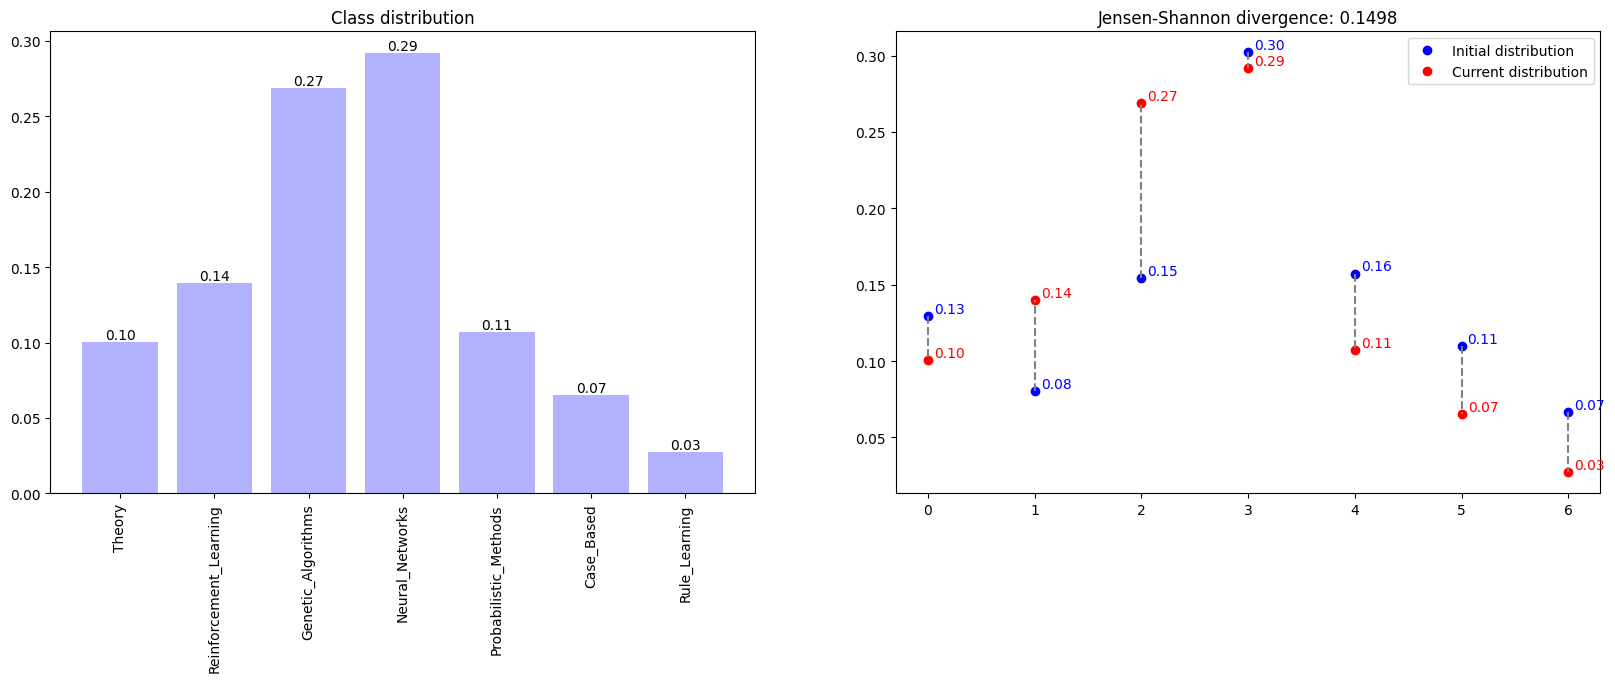

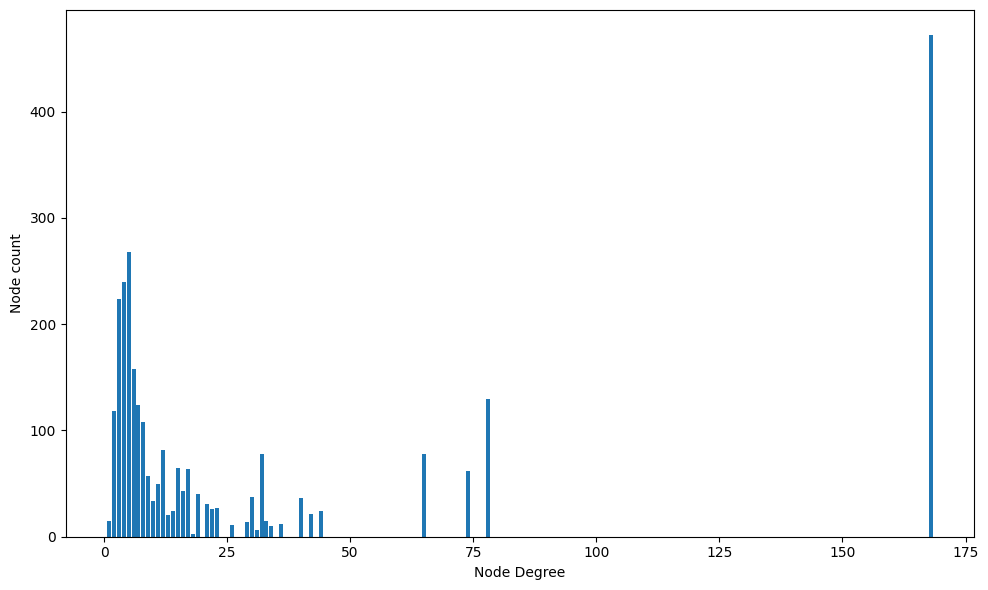

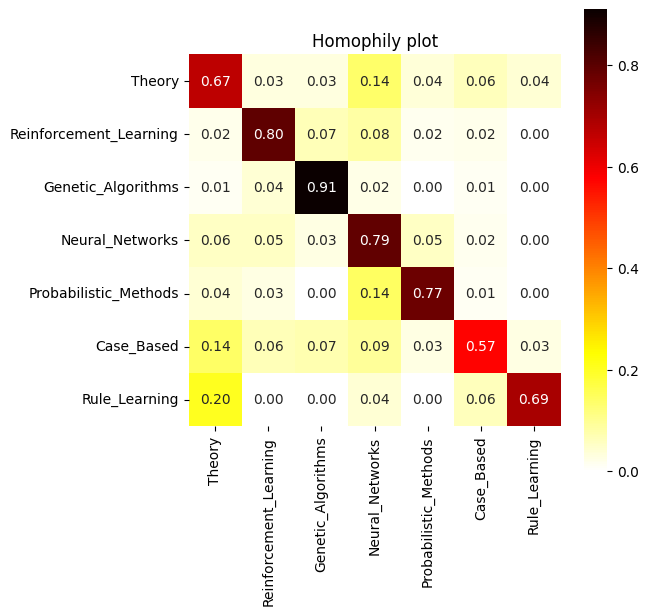

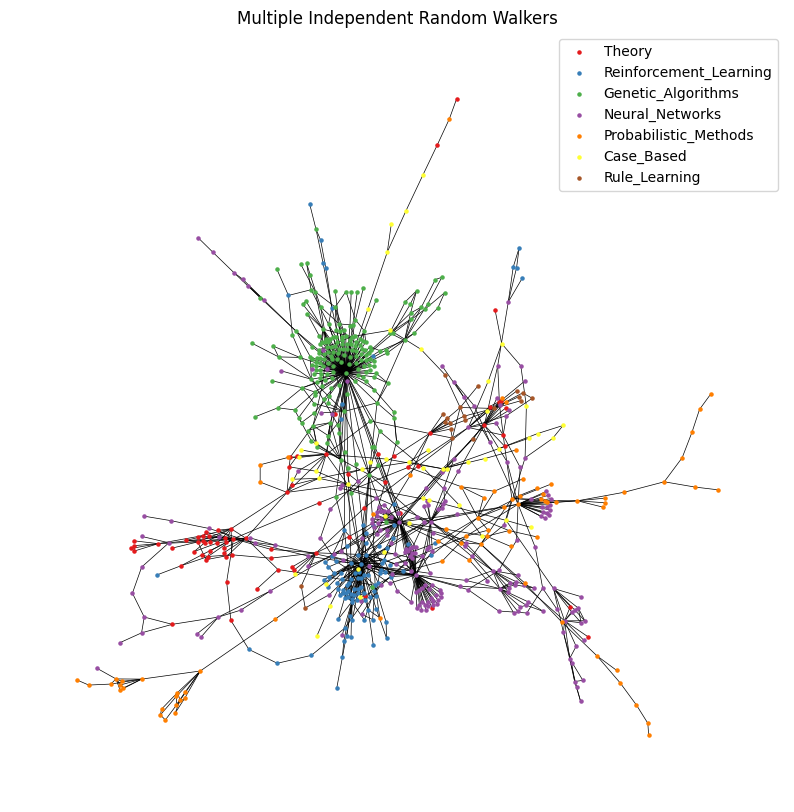

In [222]:
analyze_sampling(mirw_graph, "Multiple Independent Random Walkers", node_dist_dict)

###  Multi-Dimensional Random Walk (MDRW) or Frontier Sampling (FS)

It was born with the idea of alleviating one of the problems of sampling methods based on random walk: it is easy for exploration to get trapped in dense regions and not be able to escape. The algorithm works like this:
- Initialize a list $L=(v_0, v_1, \dots, v_l)$ with $l$ vertices according to some distribution. Initialize $V_S = E_S = \emptyset$;
- At each step, until termination, choose a node $v_i \in L$ with probability $p(v_i) \propto d_G(v_i)$ and:
  - sample a neighbor $v_j \in \mathcal{N}(v_i)$;
  - update $E_S = E_S \cup \{\{v_i, v_j\}\}$;
  - update $V_S = V_S \cup \{v_i\} \cup \{v_j\}$;
  - replace $v_j$ with $v_i$ in list $L$.

The procedure continues for a certain fixed number of iterations or until a certain fixed number of nodes has been explored. The subgraph $G_S=(V_E, E_S)$ will be composed of all the sampled edges and all the nodes $V_S$ incident to them.

In [192]:
def frontier_sampling(graph, num_samples,  num_random_walks, force):
 
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  node_samp_ids = np.random.choice(graph.num_nodes, num_random_walks, replace=False, p=probs)

  curr_degs = degs[node_samp_ids].numpy()
  L = torch.tensor(node_samp_ids)
  edges = []
  node_ids = np.array([], dtype=int)
  
  for n in node_samp_ids:
    node_ids = np.append(node_ids, n.item())
    
  node_dist_dict = {}
  n_it = 0
  max_it_before_exit = 10000

  while len(node_ids) < num_samples and n_it < max_it_before_exit:
    n_it += 1

    curr_probs = curr_degs / np.sum(curr_degs)
    curr_id = np.random.choice(L, 1, replace=False, p=curr_probs)
    curr_id = curr_id.item()
    neighs, _, _, _  = k_hop_subgraph([curr_id],
                                      1,
                                      graph.edge_index)

    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] =  1
    else:
      node_dist_dict[curr_id] += 1

    mask = neighs != curr_id
    neighs = neighs[mask]
    neighs_deg = degs[neighs].numpy()
    neighs_probs = neighs_deg / np.sum(neighs_deg)
    new_id = np.random.choice(neighs, 1, replace=False, p = neighs_probs)
    new_id = new_id.item()
    new_pos = np.where(neighs == new_id)[0].item()
    
    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
      
    mask = L.eq(curr_id)
    L[mask] = new_id
    curr_degs[mask] = neighs_deg[new_pos].item()


  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", sample_edges.shape[1], " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")

  if n_it >= max_it_before_exit:
    print("Max iterations reached. Exiting because stucked")

  return sample_graph, node_dist_dict

In [193]:
num_samples_nodes, _ = num_samples(graph, 0.7)
fs_graph, node_dist_dict = frontier_sampling(graph, num_samples_nodes, 20, force=True)

2868 iterations required to explore  812  different nodes


Number of nodes: 812
Number of node features: 1433
Number of edges: 2440
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.00
Number of classes: 7
Number of connected components: 2
Density: 0.00371
Average clustering coefficient: 0.16992
Transitivity: 0.04531


count  mean   std  min  25%  50%  75%    max
0  812.0   3.0  5.35  1.0  1.0  2.0  3.0  110.0

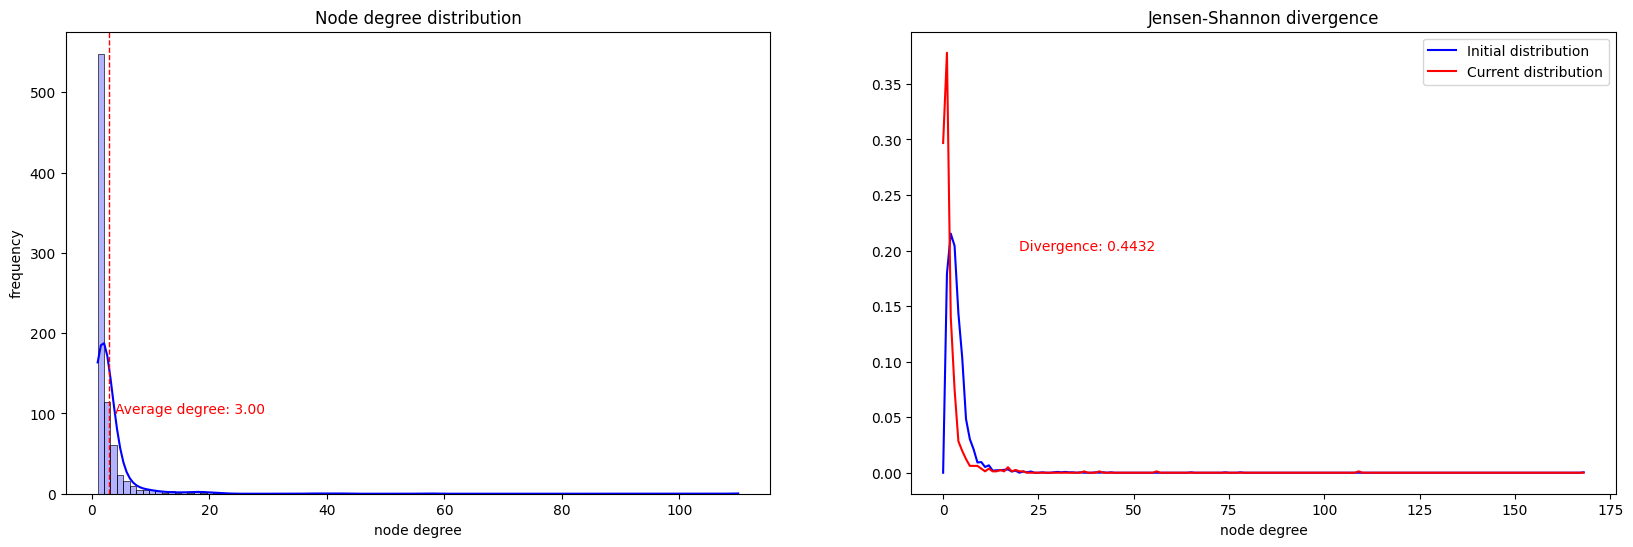

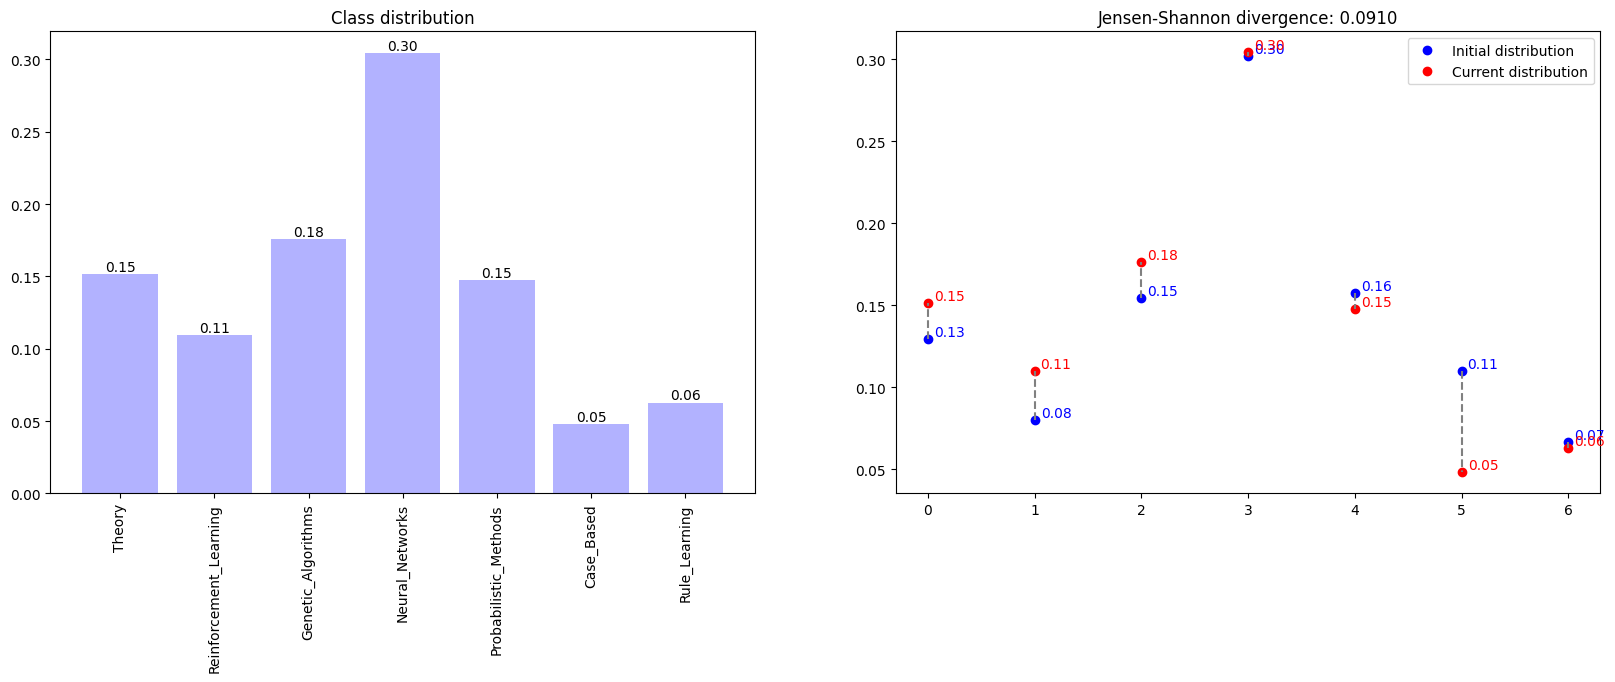

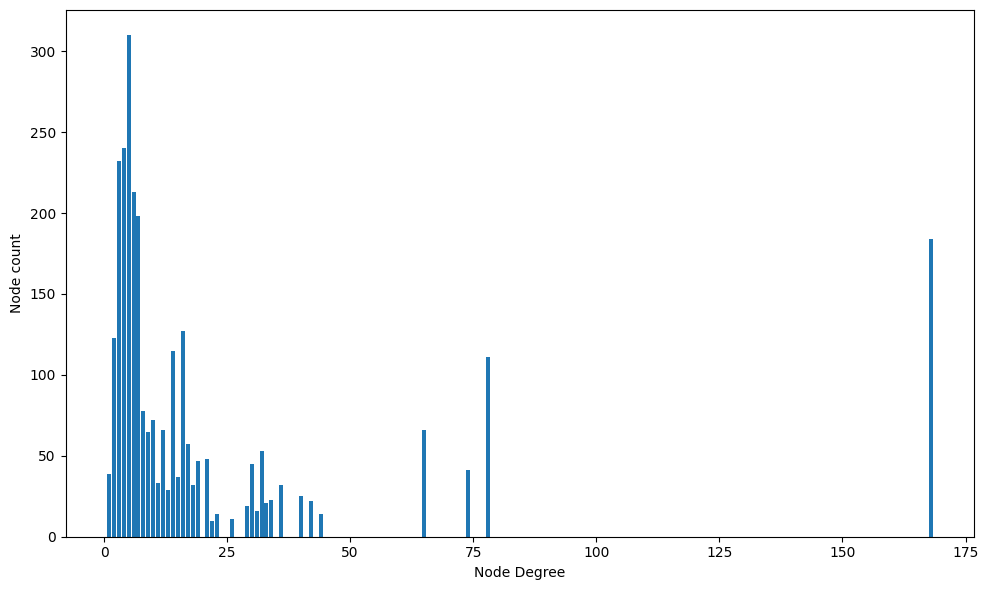

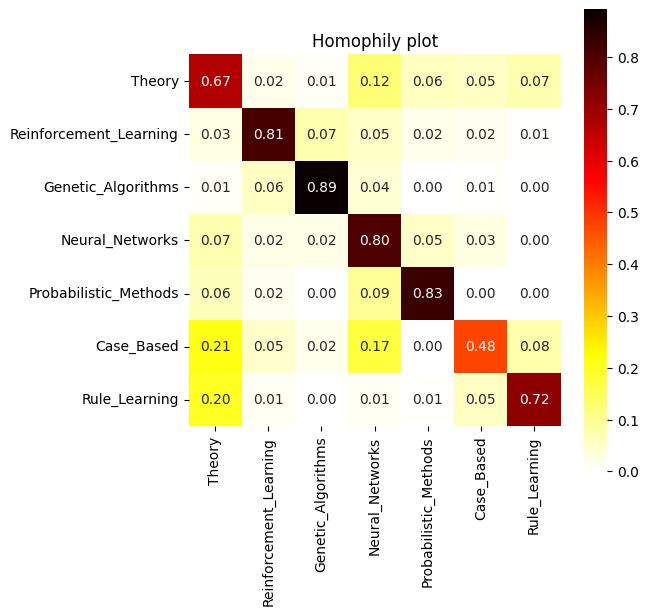

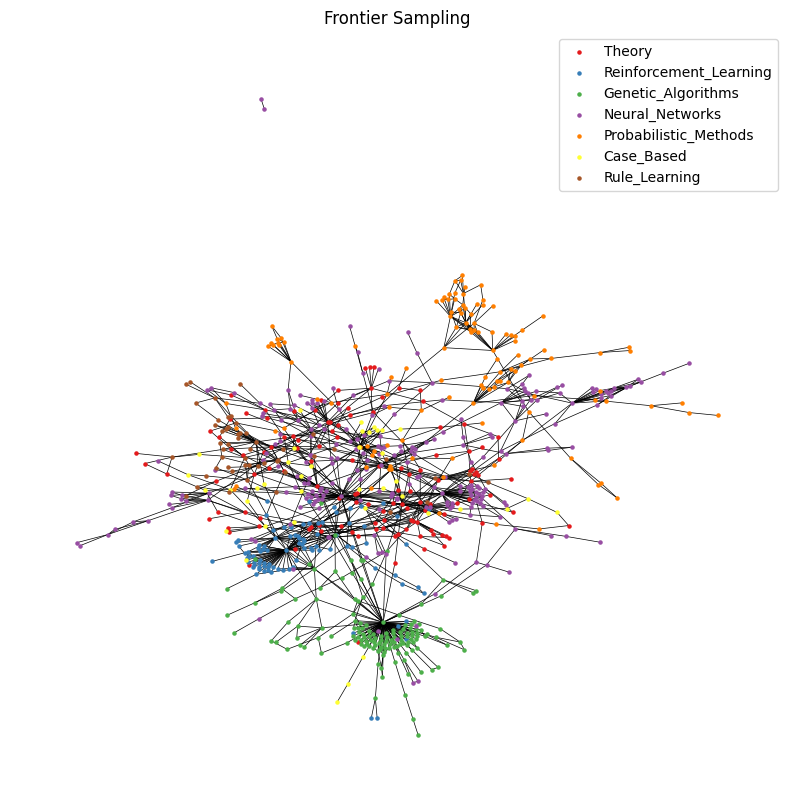

In [194]:
analyze_sampling(fs_graph, "Frontier Sampling", node_dist_dict)

### Metropolis-Hastings Random Walk

It is an algorithm usually used to obtain a certain desired distribution on the nodes. Denoted by $P_{uv}$ the matrix with the transition probabilities $u \to v$ and by $\pi_u$ the value of the distribution $\boldsymbol{\pi}$ on $u$, we have:
$$
P_{uv} =
\begin{cases}
M_{uv} \cdot \min\left\{1, \frac{\pi_v}{\pi_u} \right\} \qquad & u \neq v \:\land \: v \in \mathcal{N}( u)\\
0 & u \neq v \: \land \: v \notin \mathcal{N}(u)\\
1 - \sum_{w \in V} P_{uw} & u = v
\end{cases}
$$
Where $M_{uv}=M_{vu}$ is a normalization constant for the node pair $(u,v)$. A small value of $M_{uv}$ underweights all the probabilities of undertaking an outgoing edge from $u$ and consequently gives high importance to self-loops and dilates the mixing time for the desired node distribution. A classic choice is $M_{uv} = \min \left\{\frac{1}{d_G(u)}, \frac{1}{d_G(v)}\right\}$.

In accordance with what was said before, we will use $\boldsymbol{\\pi}$ as distribution:

$$ \forall v \in V \quad \pi_v = \frac{d_G(v)}{\sum_{u \in V} d_G(u)} \:\:\implies\:\: \min\left\{1 , \frac{\pi_v}{\pi_u} \right\} = \min\left\{1, \frac{d_G(v)}{d_G(u)} \right\}$$

in order to promote travel to very crowded areas of the network.
Leaving this aside, the procedure is identical to the random walk: it starts from a node $v_0\in V$ and, at each step it samples, starting from the current $v_i$ it samples the next $v_{i+1}$ to which it moves and update $V_S = V_S \cup \{v_{i+1}\}$, $E_S = E_S \cup \{\{v_{i}, v_{i+1}\}\}$.

In [199]:
def metropolis_hastings_random_walk_sampling(graph, num_samples, force):
  
  graph.edge_index = sort_edge_index(graph.edge_index)
  degs = degree(graph.edge_index[0], graph.num_nodes)
  probs = degs / torch.sum(degs)
  curr_id = np.random.choice(graph.num_nodes, 1, replace=False, p=probs)
  curr_id = curr_id.item()
  edges = []
  node_ids = np.array([], dtype=int)
  node_ids = np.append(node_ids, curr_id)
  node_dist_dict = {}
  n_it = 0

  while len(node_ids) < num_samples:
    n_it = n_it + 1
    neighs, _, _, _  = k_hop_subgraph(torch.tensor([curr_id]),
                                                     1,
                                                     graph.edge_index)
    if not curr_id in node_dist_dict:
      node_dist_dict[curr_id] = 1
    else:
      node_dist_dict[curr_id] += 1

    neighs_deg = degs[neighs].numpy()
    probs = np.zeros_like(neighs, dtype=float)
    curr_pos = np.where(neighs == curr_id)[0].item()
    
    p_curr = neighs_deg[curr_pos] #degs_dist[int(neighs_deg[curr_pos])]
    
    for j in range(len(neighs)):
      if j != curr_pos:
        p_neig = neighs_deg[j] #degs_dist[int(neighs_deg[j])]
        prob = min(1/neighs_deg[j],  1/ neighs_deg[curr_pos]) * min(1, p_neig/p_curr)
        probs[j] = prob

    probs[curr_pos] = 1 - np.sum(probs)
    probs = np.clip(probs, 0, None)
    probs = probs / np.sum(probs)

    new_id = np.random.choice(neighs, 1, p=probs)
    new_id = new_id.item()

    if not force or new_id not in node_ids:
      node_ids = np.append(node_ids, new_id)

    edges.append([curr_id, new_id])
    curr_id = new_id

  node_ids = np.unique(node_ids)
  edges = np.unique(np.array(edges), axis=0)
  sample_edges = torch.tensor(edges).t()
  sample_edges, _ = remove_self_loops(sample_edges)
  sample_edges = to_undirected(sample_edges)
  sample_nodes = graph.x[node_ids]
  sample_y = graph.y[node_ids]
  relabeled_edge_index = relabel_edge_index(node_ids, sample_edges)
  sample_graph = Data(x=sample_nodes, edge_index=relabeled_edge_index, y=sample_y)

  if not force:
    print("In ", num_samples, " iterations ", len(node_ids), " different nodes were explored by ", sample_edges.shape[1], " different edges")
  else:
    print(n_it, "iterations required to explore ", len(node_ids), " different nodes")


  return sample_graph, node_dist_dict

In [200]:
num_samples_nodes, _ = num_samples(graph, 0.7)
mhrw_graph, node_dist_dict = metropolis_hastings_random_walk_sampling(graph, num_samples_nodes, force=True)

6290 iterations required to explore  812  different nodes


Number of nodes: 812
Number of node features: 1433
Number of edges: 2380
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 2.93
Number of classes: 7
Number of connected components: 1
Density: 0.00361
Average clustering coefficient: 0.13680
Transitivity: 0.15140


count  mean   std  min  25%  50%  75%   max
0  812.0  2.93  1.82  1.0  2.0  2.0  4.0  20.0

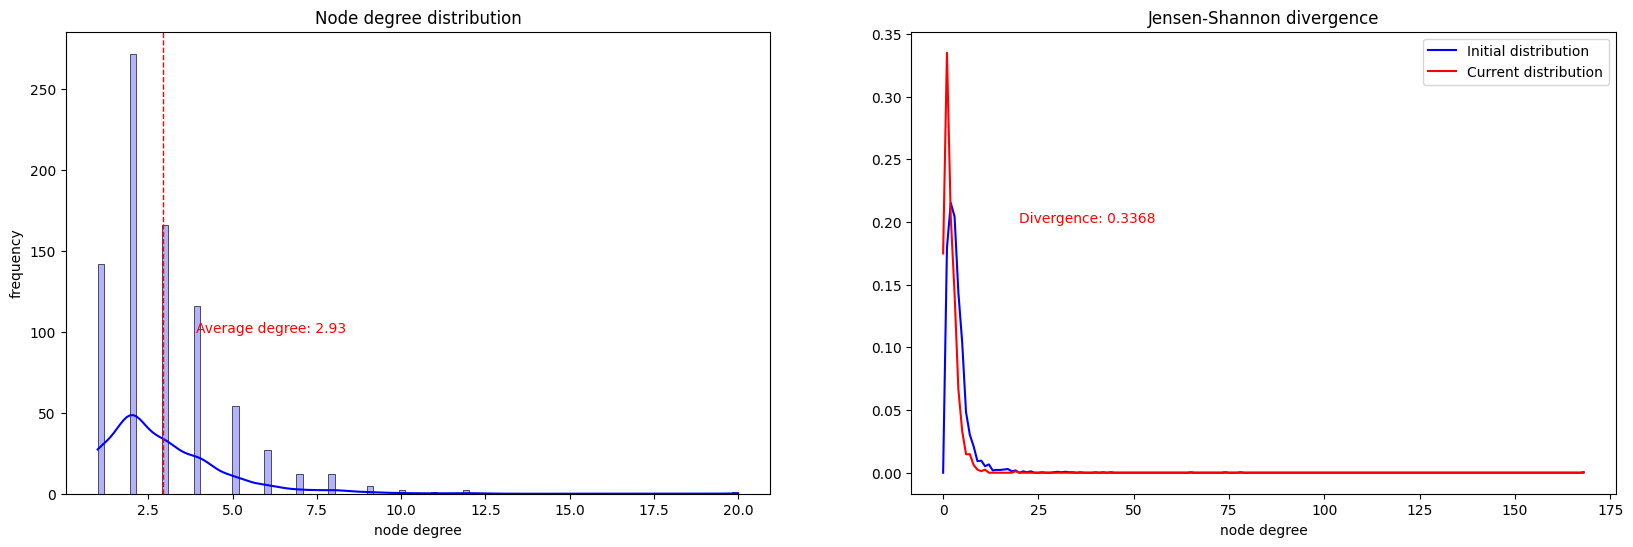

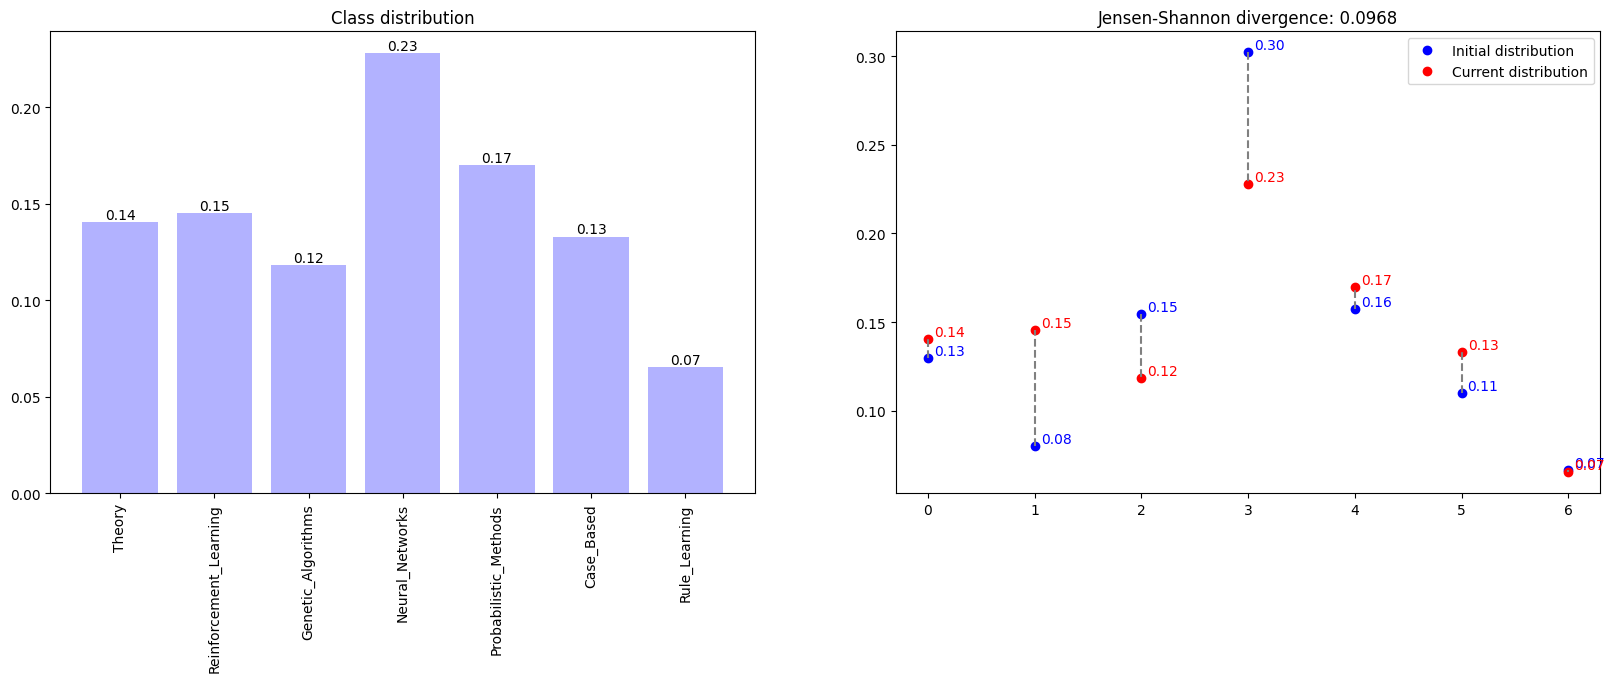

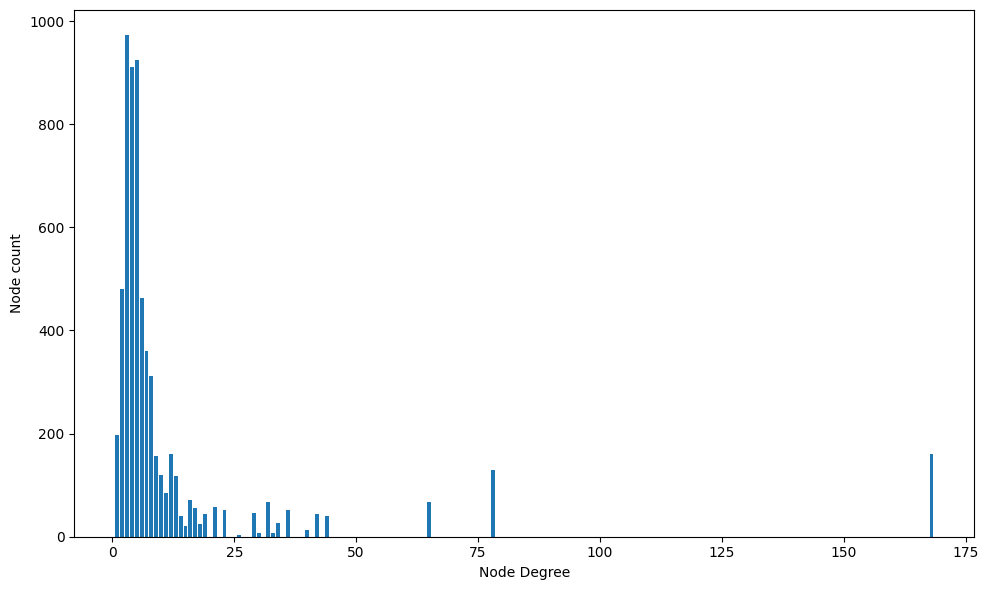

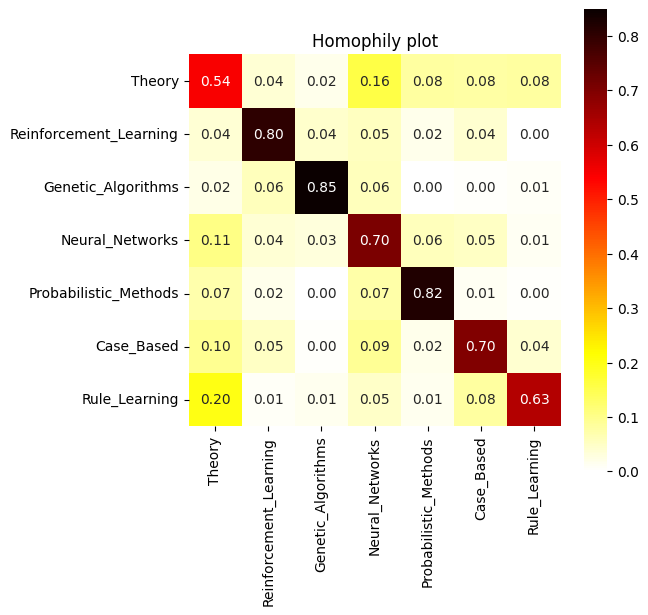

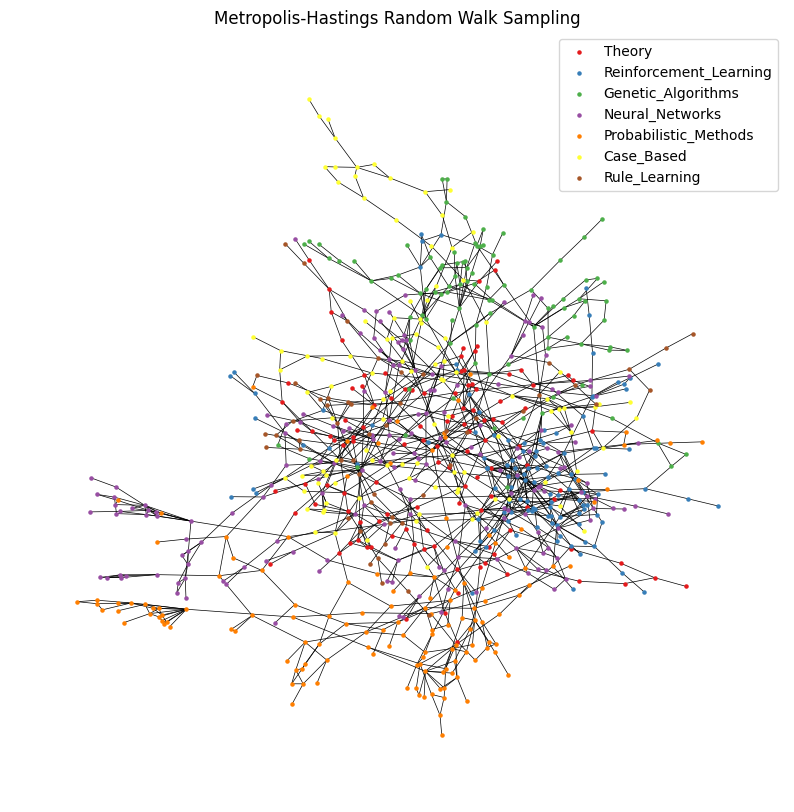

In [201]:
analyze_sampling(mhrw_graph, "Metropolis-Hastings Random Walk Sampling", node_dist_dict)